# 1.0

In [1]:
#导入相关包
import os
os.chdir("/home/uu/proj/polyA/data/")
import numpy  as np                                    #
import pandas as pd                                    #读取数据
import keras
from keras.preprocessing.text import Tokenizer         #统计碱基频率，把碱基转化成数字
from keras.utils  import np_utils                      #将数字转化成独热码的形式
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Activation
from keras.optimizers        import Adam               #优化器
from keras.callbacks import EarlyStopping              #设置早停
from keras.callbacks import ModelCheckpoint            #
from sklearn.model_selection import StratifiedKFold    #拆分数据
from sklearn.metrics import roc_auc_score,recall_score           #引入评价指数
from sklearn.metrics import precision_score,f1_score,accuracy_score   
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt                       #绘制图形


In [2]:
delta_1=[]
delta_2=[]
#读取数据
def load_data(file=None):
    """
    输入文件名，返回向量化后独热码后的numpy数组，标签
    """
    import re  #正则表达式
    df = pd.read_csv(file,header=None,names=['sequences'])
    df.loc[:,'sequences'] = df.loc[:,'sequences'].map(lambda x: list(x)) #显式索引
    
    #向量化
    vocabulary_size=10   #设定词汇量大小，因为只有4个碱基，所以设置为10
    tokenizer = Tokenizer(num_words = vocabulary_size) #初始化tokenizer函数
    tokenizer.fit_on_texts(df.loc[:,'sequences'])       #统计词汇，基于词频率
    sequences = tokenizer.texts_to_sequences(df.loc[:,'sequences']) #将atcg转化成数字1-4
    
    #删除每条序列中6个序列,然后转化为numpy数组，并设置数组元素范围为0-3,方便独热码时生成200*4的数组
    for i in range(len(sequences)):
            del sequences[i][100:106]
    sequences = np.asarray(sequences)-1
    
    #每一条序列已经是200个数字的向量
    #将200个数字(0-3)的向量转化成独热码，即200*4的矩阵,#然后重复2遍
    data = [np_utils.to_categorical(x) for x in sequences]
    data = [n.reshape((1,200,4)) for n in data]
    #data=[np.concatenate((i,i),axis=0) for i in data]
    
    #增加标签数据        
    if re.findall("neg",file):
        label = np.zeros(len(data))
    else:
        label = np.ones(len(data))
    
    return data,label

class lenet:#经典网络
    """ 网络参数"""
    def nerual():
        input_shape=(1,200,4)
        model = Sequential()
        model.add(Conv2D(filters=8,kernel_size=(3,4),padding='same',activation='relu',
                  input_shape=input_shape))
        model.add(Conv2D(filters=64,kernel_size=(6,4),padding='same',activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2),padding='same'))
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1,activation='sigmoid'))
        return model
        
def train_func(model,x_train=None,y_train=None,x_test=None,y_test=None,*ARGV):
    """编译与训练模型"""
    adam=Adam(lr=0.5*1e-4)
    model.compile(loss='binary_crossentropy',optimizer=adam,
                  metrics=['accuracy'])
    
#     tb_hist = keras.callbacks.TensorBoard(log_dir='./graph',histogram_freq=0,write_graph=True,write_images=True)
    
    hist = model.fit(x=x_train,y=y_train,batch_size=32,validation_data=(x_test,y_test),
                         epochs=50,verbose=0,shuffle=True)
    
    return model,hist

def assess_func(y_true,y_pred):
    """
    返回TP,FP,TN,FN,
    Precision   预测为正例的样本中真正正例的比例,敏感性
    recall      真正为正例的样本有多少被预测出来，
    ROC曲线      ROC是一个用于度量分类中的非均衡性的工具，ROC曲线及AUC常被用来评价一个二值分类器的优劣  
    FPR         所有的负样本中有多少被预测为正例
    TPR         等同于recall
    F-measure   precison和recall的调和平均值。没有一个单个的度量可以告诉所有的信息，所以建议使用多个度量
    """
    
    acc       = accuracy_score( y_true,np.array(y_pred>0.5,dtype=int))
    recal     = recall_score(   y_true,np.array(y_pred>0.5,dtype=int))
    precision = precision_score(y_true,np.array(y_pred>0.5,dtype=int))
    f1        = f1_score(       y_true,np.array(y_pred>0.5,dtype=int))
    auc       = roc_auc_score(  y_true,y_pred)  #返回的是auc
    
    
    return (acc,recal,precision,f1,auc)

def report(result_total):
    polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
    mean_std=[]
    mean_std_2=[]
    
    #数据报表，各种指标为平均值±std
    for a in [i.describe().loc['mean':'std',:] for i in result_total]:
        mean_std_2=[]
        for i in range(5):
            delta = "{:.1f}±{:.0f}".format(a.iloc[0,i]*100,a.iloc[1,i]*100)
            mean_std_2.append(delta)
        mean_std.append(mean_std_2)
        
    acc    = pd.DataFrame(np.array([i.loc[:,'acc'] for i in access_1]).T,columns=polys)
    pre    = pd.DataFrame(np.array([i.loc[:,'pre'] for i in access_1]).T,columns=polys)
    recall = pd.DataFrame(np.array([i.loc[:,'recall'] for i in access_1]).T,columns=polys)
    f1     = pd.DataFrame(np.array([i.loc[:,'f1'] for i in access_1]).T,columns=polys)
    auc    = pd.DataFrame(np.array([i.loc[:,'auc'] for i in access_1]).T,columns=polys)


    plt.title('acc')
    acc.boxplot()
    plt.xticks(rotation=-90) 
    plt.ylim(0,1)
    plt.show()


    plt.title('f1')
    f1.boxplot()
    plt.xticks(rotation=-90) 
    plt.ylim(0,1)
    plt.show()

    plt.title('auc')
    auc.boxplot()
    plt.xticks(rotation=-90) 
    plt.set_tile='auc'
    plt.ylim(0,1)
    plt.show()
    
    return(mean_std)

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6930 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.4865
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.5465 - val_loss: 0.6893 - val_accuracy: 0.5135
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6785 - accuracy: 0.6697 - val_loss: 0.6844 - val_accuracy: 0.4865
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6721 - accuracy: 0.7117 - val_loss: 0.6798 - val_accuracy: 0.6486
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6666 - accuracy: 0.7177 - val_loss: 0.6753 - val_accuracy: 0.6486
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6582 - accuracy: 0.7357 - val_loss: 0.6695 - val_accuracy: 0.6757
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6474 - accuracy: 0.7628 - val_loss: 0.6637 - val_accuracy: 0.6486
Epoch 8/

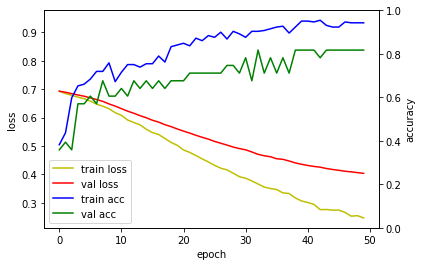

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 13ms/step - loss: 0.6910 - accuracy: 0.5345 - val_loss: 0.6890 - val_accuracy: 0.5676
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.6577 - val_loss: 0.6848 - val_accuracy: 0.6757
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.6847 - val_loss: 0.6799 - val_accuracy: 0.6757
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6746 - accuracy: 0.7027 - val_loss: 0.6765 - val_accuracy: 0.6757
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6673 - accuracy: 0.7538 - val_loss: 0.6718 - val_accuracy: 0.6486
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6601 - accuracy: 0.7357 - val_loss: 0.6666 - val_accuracy: 0.6216
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6562 - accuracy: 0.7357 - val_loss: 0.6613 - val_accuracy: 0.6757
Epoch 8/

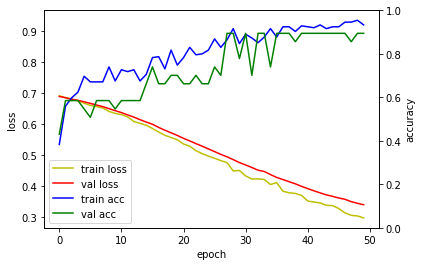

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6922 - accuracy: 0.5255 - val_loss: 0.6872 - val_accuracy: 0.7027
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.5916 - val_loss: 0.6837 - val_accuracy: 0.5405
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6787 - accuracy: 0.6517 - val_loss: 0.6786 - val_accuracy: 0.6216
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.7087 - val_loss: 0.6736 - val_accuracy: 0.6486
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6662 - accuracy: 0.7327 - val_loss: 0.6683 - val_accuracy: 0.6757
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6577 - accuracy: 0.7988 - val_loss: 0.6637 - val_accuracy: 0.6757
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6503 - accuracy: 0.7598 - val_loss: 0.6578 - val_accuracy: 0.7297
Epoch 8/

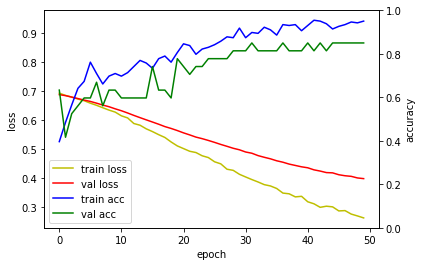

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6916 - accuracy: 0.5405 - val_loss: 0.6901 - val_accuracy: 0.5676
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.6246 - val_loss: 0.6860 - val_accuracy: 0.5676
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6577 - val_loss: 0.6820 - val_accuracy: 0.6216
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.7087 - val_loss: 0.6773 - val_accuracy: 0.7568
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6775 - accuracy: 0.6727 - val_loss: 0.6737 - val_accuracy: 0.6216
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6706 - accuracy: 0.7387 - val_loss: 0.6689 - val_accuracy: 0.7568
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6691 - accuracy: 0.7087 - val_loss: 0.6622 - val_accuracy: 0.7568
Epoch 8/

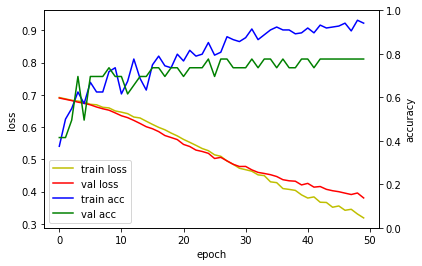

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 13ms/step - loss: 0.6893 - accuracy: 0.5435 - val_loss: 0.6859 - val_accuracy: 0.5946
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.6637 - val_loss: 0.6808 - val_accuracy: 0.6757
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.6787 - val_loss: 0.6769 - val_accuracy: 0.6757
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6695 - accuracy: 0.6787 - val_loss: 0.6709 - val_accuracy: 0.7297
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6621 - accuracy: 0.6757 - val_loss: 0.6658 - val_accuracy: 0.6216
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6565 - accuracy: 0.6967 - val_loss: 0.6604 - val_accuracy: 0.6757
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 0.7267 - val_loss: 0.6538 - val_accuracy: 0.6486
Epoch 8/

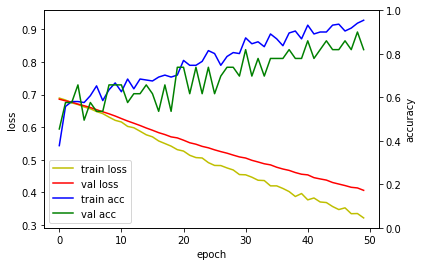

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6894 - accuracy: 0.5736 - val_loss: 0.6864 - val_accuracy: 0.7027
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6849 - accuracy: 0.6366 - val_loss: 0.6824 - val_accuracy: 0.6757
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6778 - accuracy: 0.6757 - val_loss: 0.6785 - val_accuracy: 0.6486
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.6787 - val_loss: 0.6746 - val_accuracy: 0.5946
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6639 - accuracy: 0.7237 - val_loss: 0.6676 - val_accuracy: 0.7297
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6541 - accuracy: 0.7988 - val_loss: 0.6620 - val_accuracy: 0.7568
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6450 - accuracy: 0.7778 - val_loss: 0.6567 - val_accuracy: 0.6757
Epoch 8/

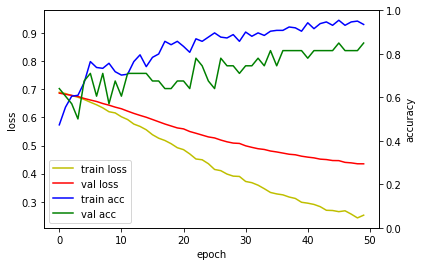

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 15ms/step - loss: 0.6918 - accuracy: 0.5586 - val_loss: 0.6886 - val_accuracy: 0.7027
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.6156 - val_loss: 0.6854 - val_accuracy: 0.6757
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.6547 - val_loss: 0.6823 - val_accuracy: 0.6216
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.6787 - val_loss: 0.6790 - val_accuracy: 0.6216
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6691 - accuracy: 0.7177 - val_loss: 0.6754 - val_accuracy: 0.5946
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6647 - accuracy: 0.7027 - val_loss: 0.6712 - val_accuracy: 0.6216
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6556 - accuracy: 0.7508 - val_loss: 0.6677 - val_accuracy: 0.6216
Epoch 8/

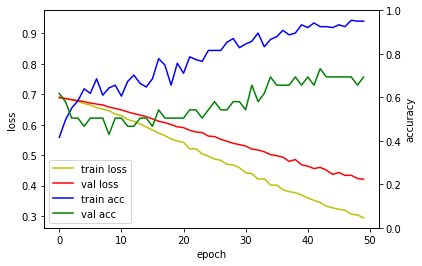

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6952 - accuracy: 0.4565 - val_loss: 0.6924 - val_accuracy: 0.4865
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.6246 - val_loss: 0.6886 - val_accuracy: 0.6486
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.6907 - val_loss: 0.6836 - val_accuracy: 0.6757
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6761 - accuracy: 0.7297 - val_loss: 0.6773 - val_accuracy: 0.7027
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6701 - accuracy: 0.7477 - val_loss: 0.6711 - val_accuracy: 0.7027
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6611 - accuracy: 0.7868 - val_loss: 0.6643 - val_accuracy: 0.7027
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6557 - accuracy: 0.7838 - val_loss: 0.6572 - val_accuracy: 0.7568
Epoch 8/

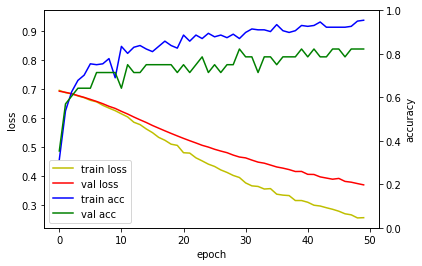

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6962 - accuracy: 0.5045 - val_loss: 0.6943 - val_accuracy: 0.4865
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5706 - val_loss: 0.6890 - val_accuracy: 0.6486
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6877 - val_loss: 0.6866 - val_accuracy: 0.5405
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6782 - accuracy: 0.6997 - val_loss: 0.6846 - val_accuracy: 0.6216
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6711 - accuracy: 0.6787 - val_loss: 0.6812 - val_accuracy: 0.6216
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6653 - accuracy: 0.6637 - val_loss: 0.6781 - val_accuracy: 0.6216
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6621 - accuracy: 0.6607 - val_loss: 0.6747 - val_accuracy: 0.6216
Epoch 8/

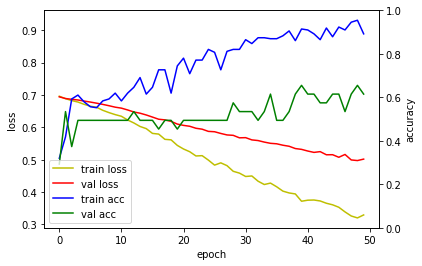

第1个：AATAGA
Epoch 1/50
11/11 [==============================] - 0s 14ms/step - loss: 0.6895 - accuracy: 0.5766 - val_loss: 0.6856 - val_accuracy: 0.7027
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6832 - accuracy: 0.6547 - val_loss: 0.6786 - val_accuracy: 0.7838
Epoch 3/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6754 - accuracy: 0.6757 - val_loss: 0.6714 - val_accuracy: 0.6757
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6676 - accuracy: 0.7207 - val_loss: 0.6631 - val_accuracy: 0.7568
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6617 - accuracy: 0.7117 - val_loss: 0.6563 - val_accuracy: 0.7297
Epoch 6/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6513 - accuracy: 0.7778 - val_loss: 0.6479 - val_accuracy: 0.8649
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 0.6440 - accuracy: 0.7477 - val_loss: 0.6395 - val_accuracy: 0.7027
Epoch 8/

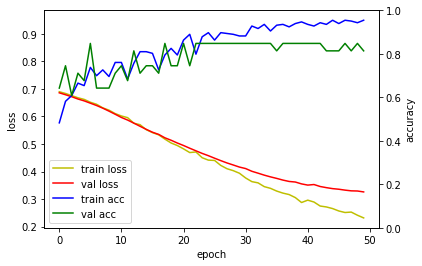

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 32ms/step - loss: 0.6970 - accuracy: 0.4499 - val_loss: 0.6920 - val_accuracy: 0.4634
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5122 - val_loss: 0.6907 - val_accuracy: 0.5610
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5664 - val_loss: 0.6899 - val_accuracy: 0.5854
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5962 - val_loss: 0.6879 - val_accuracy: 0.5366
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.6883 - val_loss: 0.6864 - val_accuracy: 0.6341
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.6883 - val_loss: 0.6849 - val_accuracy: 0.6585
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.7100 - val_loss: 0.6831 - val_accuracy: 0.6341
Epoch 8/

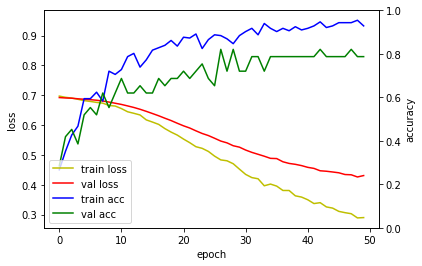

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6926 - accuracy: 0.5257 - val_loss: 0.6902 - val_accuracy: 0.7073
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5610 - val_loss: 0.6877 - val_accuracy: 0.5854
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.6721 - val_loss: 0.6854 - val_accuracy: 0.8293
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.6125 - val_loss: 0.6840 - val_accuracy: 0.5610
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6794 - accuracy: 0.6938 - val_loss: 0.6792 - val_accuracy: 0.7561
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.7046 - val_loss: 0.6758 - val_accuracy: 0.8049
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6720 - accuracy: 0.7615 - val_loss: 0.6721 - val_accuracy: 0.8293
Epoch 8/

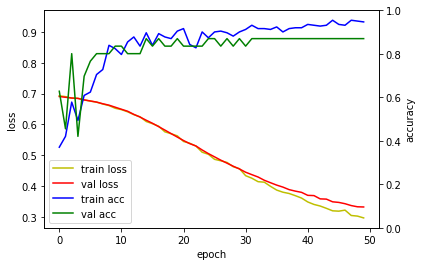

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6926 - accuracy: 0.5068 - val_loss: 0.6923 - val_accuracy: 0.4390
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5176 - val_loss: 0.6906 - val_accuracy: 0.4878
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5799 - val_loss: 0.6889 - val_accuracy: 0.4878
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.7154 - val_loss: 0.6864 - val_accuracy: 0.6585
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.6911 - val_loss: 0.6838 - val_accuracy: 0.6341
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6714 - accuracy: 0.7642 - val_loss: 0.6797 - val_accuracy: 0.6829
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6684 - accuracy: 0.7642 - val_loss: 0.6766 - val_accuracy: 0.6829
Epoch 8/

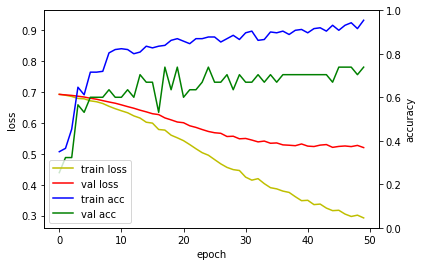

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6927 - accuracy: 0.4851 - val_loss: 0.6893 - val_accuracy: 0.5366
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5583 - val_loss: 0.6874 - val_accuracy: 0.6341
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.6585 - val_loss: 0.6852 - val_accuracy: 0.5854
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.6504 - val_loss: 0.6821 - val_accuracy: 0.6585
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.7209 - val_loss: 0.6784 - val_accuracy: 0.6829
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6729 - accuracy: 0.7209 - val_loss: 0.6742 - val_accuracy: 0.6829
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6663 - accuracy: 0.7344 - val_loss: 0.6695 - val_accuracy: 0.7805
Epoch 8/

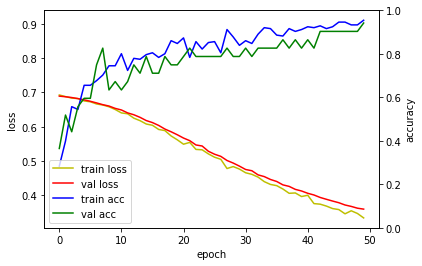

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.4932 - val_loss: 0.6896 - val_accuracy: 0.5610
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5528 - val_loss: 0.6882 - val_accuracy: 0.7317
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.6938 - val_loss: 0.6854 - val_accuracy: 0.7317
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.7073 - val_loss: 0.6832 - val_accuracy: 0.7073
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6777 - accuracy: 0.7371 - val_loss: 0.6809 - val_accuracy: 0.7073
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6720 - accuracy: 0.7886 - val_loss: 0.6771 - val_accuracy: 0.7073
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6650 - accuracy: 0.8184 - val_loss: 0.6726 - val_accuracy: 0.8049
Epoch 8/

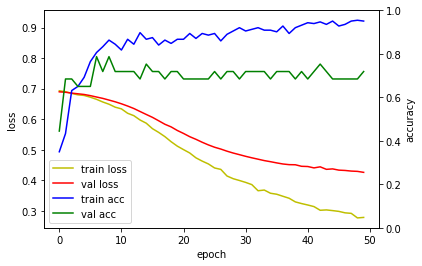

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6937 - accuracy: 0.4715 - val_loss: 0.6939 - val_accuracy: 0.4878
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.6260 - val_loss: 0.6918 - val_accuracy: 0.5122
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.6314 - val_loss: 0.6895 - val_accuracy: 0.6098
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.6992 - val_loss: 0.6870 - val_accuracy: 0.7073
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6777 - accuracy: 0.7534 - val_loss: 0.6835 - val_accuracy: 0.7317
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.7805 - val_loss: 0.6786 - val_accuracy: 0.7073
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6672 - accuracy: 0.7480 - val_loss: 0.6737 - val_accuracy: 0.7805
Epoch 8/

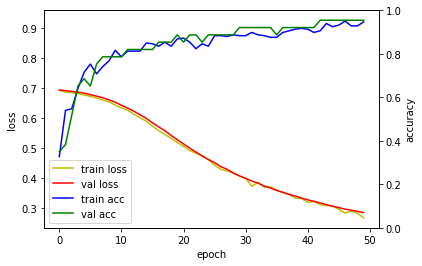

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6903 - accuracy: 0.5230 - val_loss: 0.6901 - val_accuracy: 0.5122
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5501 - val_loss: 0.6872 - val_accuracy: 0.6585
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.6125 - val_loss: 0.6861 - val_accuracy: 0.6098
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.6260 - val_loss: 0.6823 - val_accuracy: 0.6829
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.6992 - val_loss: 0.6794 - val_accuracy: 0.7073
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6708 - accuracy: 0.7073 - val_loss: 0.6762 - val_accuracy: 0.7073
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6668 - accuracy: 0.7073 - val_loss: 0.6722 - val_accuracy: 0.7317
Epoch 8/

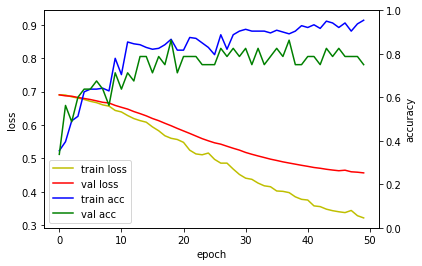

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6919 - accuracy: 0.5339 - val_loss: 0.6899 - val_accuracy: 0.6585
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5583 - val_loss: 0.6874 - val_accuracy: 0.5366
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5989 - val_loss: 0.6848 - val_accuracy: 0.5610
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6802 - val_loss: 0.6815 - val_accuracy: 0.7805
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6782 - accuracy: 0.7154 - val_loss: 0.6779 - val_accuracy: 0.7805
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6756 - accuracy: 0.6992 - val_loss: 0.6743 - val_accuracy: 0.7805
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6697 - accuracy: 0.7317 - val_loss: 0.6710 - val_accuracy: 0.7073
Epoch 8/

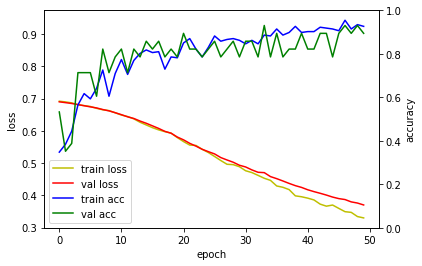

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.5312 - val_loss: 0.6912 - val_accuracy: 0.5610
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6179 - val_loss: 0.6889 - val_accuracy: 0.6098
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6830 - accuracy: 0.7046 - val_loss: 0.6862 - val_accuracy: 0.5854
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.6802 - val_loss: 0.6831 - val_accuracy: 0.6098
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6737 - accuracy: 0.7642 - val_loss: 0.6792 - val_accuracy: 0.6585
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6679 - accuracy: 0.7995 - val_loss: 0.6746 - val_accuracy: 0.7317
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6625 - accuracy: 0.7588 - val_loss: 0.6692 - val_accuracy: 0.7317
Epoch 8/

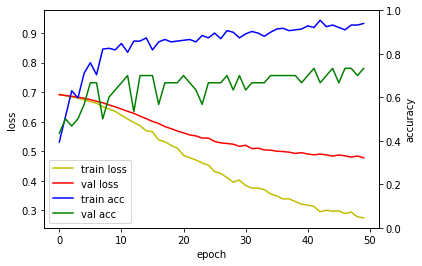

第2个：AATATA
Epoch 1/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6938 - accuracy: 0.4986 - val_loss: 0.6901 - val_accuracy: 0.6341
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5339 - val_loss: 0.6889 - val_accuracy: 0.6098
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.6856 - val_loss: 0.6871 - val_accuracy: 0.6829
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6152 - val_loss: 0.6859 - val_accuracy: 0.5122
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.6504 - val_loss: 0.6822 - val_accuracy: 0.7073
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.7100 - val_loss: 0.6791 - val_accuracy: 0.7073
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6703 - accuracy: 0.7398 - val_loss: 0.6767 - val_accuracy: 0.7073
Epoch 8/

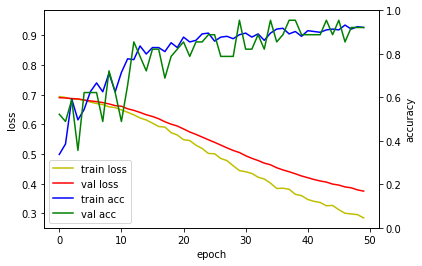

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6904 - accuracy: 0.5718 - val_loss: 0.6917 - val_accuracy: 0.5610
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.6369 - val_loss: 0.6906 - val_accuracy: 0.4878
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.5908 - val_loss: 0.6892 - val_accuracy: 0.4878
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6768 - accuracy: 0.6829 - val_loss: 0.6872 - val_accuracy: 0.5366
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.6585 - val_loss: 0.6853 - val_accuracy: 0.6098
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6717 - accuracy: 0.7507 - val_loss: 0.6824 - val_accuracy: 0.6829
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6676 - accuracy: 0.7642 - val_loss: 0.6802 - val_accuracy: 0.7073
Epoch 8/

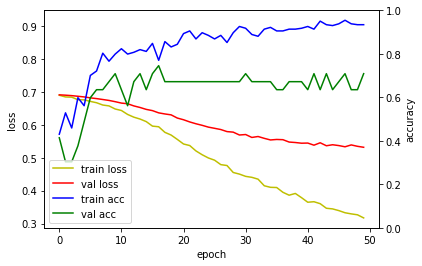

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 14ms/step - loss: 0.6922 - accuracy: 0.5339 - val_loss: 0.6921 - val_accuracy: 0.6341
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.6233 - val_loss: 0.6901 - val_accuracy: 0.6829
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5637 - val_loss: 0.6877 - val_accuracy: 0.5610
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.6640 - val_loss: 0.6866 - val_accuracy: 0.6829
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.7317 - val_loss: 0.6838 - val_accuracy: 0.7317
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.7344 - val_loss: 0.6816 - val_accuracy: 0.6829
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.7209 - val_loss: 0.6787 - val_accuracy: 0.6829
Epoch 8/

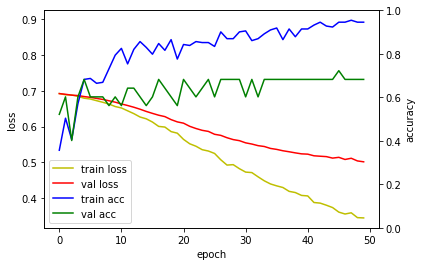

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 14ms/step - loss: 0.6913 - accuracy: 0.5095 - val_loss: 0.6925 - val_accuracy: 0.5610
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5772 - val_loss: 0.6917 - val_accuracy: 0.4878
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.6396 - val_loss: 0.6894 - val_accuracy: 0.5854
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6832 - accuracy: 0.6314 - val_loss: 0.6891 - val_accuracy: 0.4878
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6790 - accuracy: 0.6558 - val_loss: 0.6868 - val_accuracy: 0.5122
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6760 - accuracy: 0.7100 - val_loss: 0.6847 - val_accuracy: 0.5610
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.6043 - val_loss: 0.6841 - val_accuracy: 0.4878
Epoch 8/

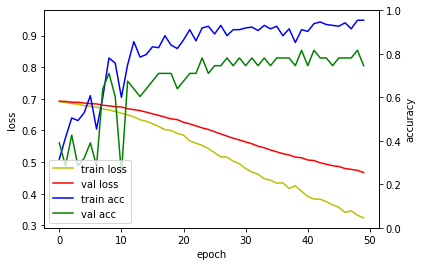

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.4986 - val_loss: 0.6920 - val_accuracy: 0.4878
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5827 - val_loss: 0.6905 - val_accuracy: 0.5854
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.6016 - val_loss: 0.6898 - val_accuracy: 0.5366
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6260 - val_loss: 0.6893 - val_accuracy: 0.5366
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6840 - accuracy: 0.5935 - val_loss: 0.6881 - val_accuracy: 0.5610
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.6477 - val_loss: 0.6865 - val_accuracy: 0.6585
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6772 - accuracy: 0.6883 - val_loss: 0.6852 - val_accuracy: 0.6585
Epoch 8/

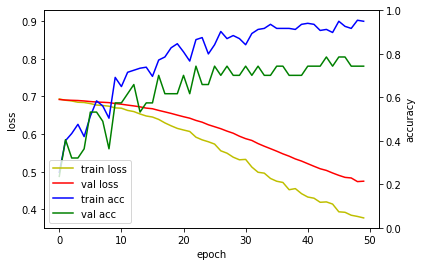

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6934 - accuracy: 0.4851 - val_loss: 0.6912 - val_accuracy: 0.5610
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5908 - val_loss: 0.6903 - val_accuracy: 0.5122
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5501 - val_loss: 0.6892 - val_accuracy: 0.5366
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.6721 - val_loss: 0.6876 - val_accuracy: 0.6585
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.7127 - val_loss: 0.6858 - val_accuracy: 0.6829
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6795 - accuracy: 0.6856 - val_loss: 0.6835 - val_accuracy: 0.6585
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6769 - accuracy: 0.7073 - val_loss: 0.6810 - val_accuracy: 0.6829
Epoch 8/

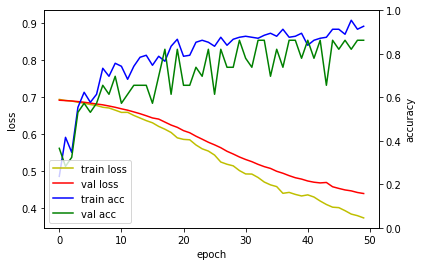

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5122 - val_loss: 0.6958 - val_accuracy: 0.4634
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5827 - val_loss: 0.6948 - val_accuracy: 0.3415
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6860 - accuracy: 0.6911 - val_loss: 0.6944 - val_accuracy: 0.5122
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6836 - accuracy: 0.6612 - val_loss: 0.6937 - val_accuracy: 0.5854
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.7100 - val_loss: 0.6926 - val_accuracy: 0.6098
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6792 - accuracy: 0.7236 - val_loss: 0.6915 - val_accuracy: 0.6098
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.7588 - val_loss: 0.6898 - val_accuracy: 0.5854
Epoch 8/

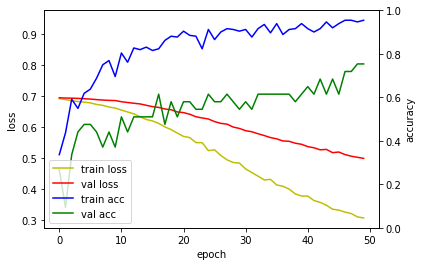

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.5230 - val_loss: 0.6928 - val_accuracy: 0.4634
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.6043 - val_loss: 0.6916 - val_accuracy: 0.5122
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6860 - accuracy: 0.6423 - val_loss: 0.6909 - val_accuracy: 0.4878
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.6694 - val_loss: 0.6885 - val_accuracy: 0.6098
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.7019 - val_loss: 0.6867 - val_accuracy: 0.6829
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.7019 - val_loss: 0.6855 - val_accuracy: 0.6829
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6748 - accuracy: 0.7696 - val_loss: 0.6845 - val_accuracy: 0.5854
Epoch 8/

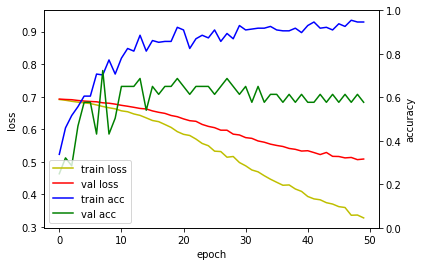

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 13ms/step - loss: 0.6942 - accuracy: 0.4661 - val_loss: 0.6898 - val_accuracy: 0.6098
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5474 - val_loss: 0.6889 - val_accuracy: 0.7073
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5718 - val_loss: 0.6887 - val_accuracy: 0.4878
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.5827 - val_loss: 0.6867 - val_accuracy: 0.5854
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.6179 - val_loss: 0.6851 - val_accuracy: 0.5366
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy: 0.7100 - val_loss: 0.6826 - val_accuracy: 0.8293
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.7724 - val_loss: 0.6810 - val_accuracy: 0.7561
Epoch 8/

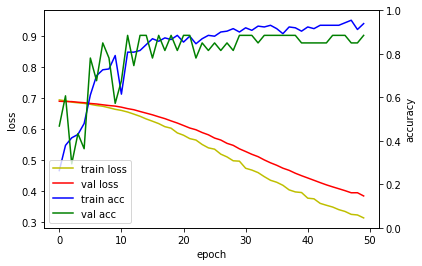

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6927 - accuracy: 0.4986 - val_loss: 0.6915 - val_accuracy: 0.6098
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5718 - val_loss: 0.6896 - val_accuracy: 0.5122
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5420 - val_loss: 0.6881 - val_accuracy: 0.5122
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5583 - val_loss: 0.6870 - val_accuracy: 0.5122
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.6748 - val_loss: 0.6857 - val_accuracy: 0.5366
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6773 - accuracy: 0.6721 - val_loss: 0.6840 - val_accuracy: 0.5610
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6739 - accuracy: 0.7453 - val_loss: 0.6825 - val_accuracy: 0.5854
Epoch 8/

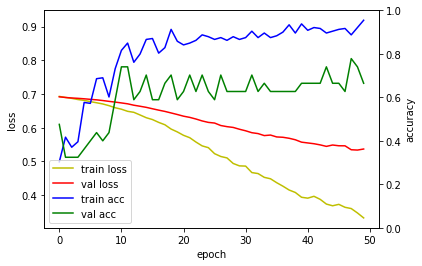

第3个：CATAAA
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6958 - val_accuracy: 0.4878
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5285 - val_loss: 0.6957 - val_accuracy: 0.4878
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.6098 - val_loss: 0.6953 - val_accuracy: 0.4146
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.6423 - val_loss: 0.6939 - val_accuracy: 0.4878
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.6098 - val_loss: 0.6925 - val_accuracy: 0.5122
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6784 - accuracy: 0.6856 - val_loss: 0.6917 - val_accuracy: 0.5610
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6753 - accuracy: 0.6640 - val_loss: 0.6897 - val_accuracy: 0.5854
Epoch 8/

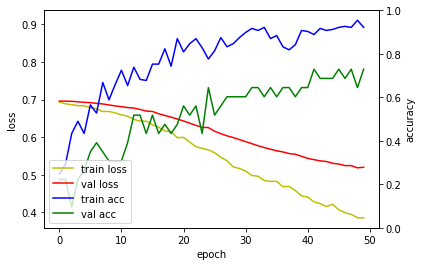

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 34ms/step - loss: 0.6937 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5362 - val_loss: 0.6929 - val_accuracy: 0.5435
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5966 - val_loss: 0.6913 - val_accuracy: 0.5870
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.6425 - val_loss: 0.6903 - val_accuracy: 0.5652
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6840 - accuracy: 0.6522 - val_loss: 0.6891 - val_accuracy: 0.5435
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.6014 - val_loss: 0.6871 - val_accuracy: 0.5652
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.7126 - val_loss: 0.6852 - val_accuracy: 0.6304
Epoch 8/

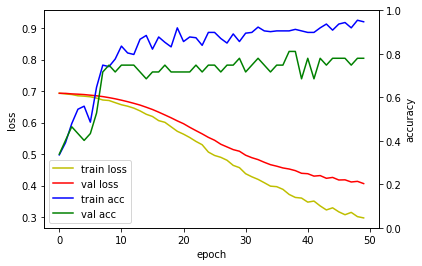

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 13ms/step - loss: 0.6942 - accuracy: 0.4831 - val_loss: 0.6914 - val_accuracy: 0.6087
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5242 - val_loss: 0.6906 - val_accuracy: 0.5217
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5459 - val_loss: 0.6894 - val_accuracy: 0.6739
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5773 - val_loss: 0.6885 - val_accuracy: 0.6304
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.7005 - val_loss: 0.6868 - val_accuracy: 0.7174
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6401 - val_loss: 0.6861 - val_accuracy: 0.5870
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.6425 - val_loss: 0.6850 - val_accuracy: 0.6739
Epoch 8/

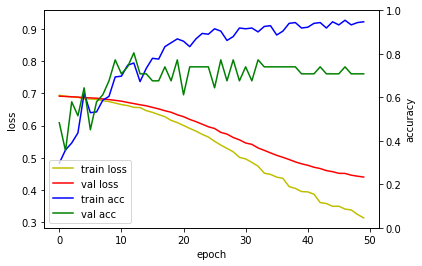

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6947 - accuracy: 0.4903 - val_loss: 0.6910 - val_accuracy: 0.5435
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5749 - val_loss: 0.6895 - val_accuracy: 0.5870
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.6377 - val_loss: 0.6875 - val_accuracy: 0.5870
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.7077 - val_loss: 0.6849 - val_accuracy: 0.6087
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.7150 - val_loss: 0.6819 - val_accuracy: 0.6739
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6733 - accuracy: 0.7464 - val_loss: 0.6786 - val_accuracy: 0.7826
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6673 - accuracy: 0.7512 - val_loss: 0.6751 - val_accuracy: 0.6087
Epoch 8/

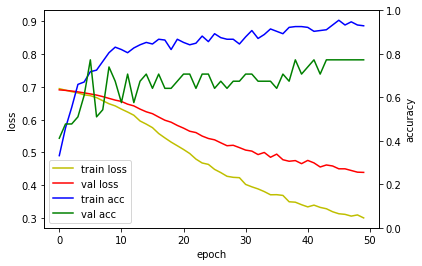

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6943 - accuracy: 0.5048 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5459 - val_loss: 0.6890 - val_accuracy: 0.6304
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5966 - val_loss: 0.6879 - val_accuracy: 0.6522
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.6304 - val_loss: 0.6861 - val_accuracy: 0.6522
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.6425 - val_loss: 0.6845 - val_accuracy: 0.5217
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.6522 - val_loss: 0.6828 - val_accuracy: 0.5652
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6731 - accuracy: 0.7319 - val_loss: 0.6801 - val_accuracy: 0.7609
Epoch 8/

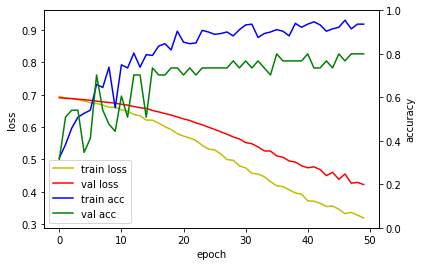

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.4734 - val_loss: 0.6915 - val_accuracy: 0.5217
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5435 - val_loss: 0.6892 - val_accuracy: 0.5435
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5411 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5942 - val_loss: 0.6856 - val_accuracy: 0.6522
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.6184 - val_loss: 0.6831 - val_accuracy: 0.6304
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.6884 - val_loss: 0.6812 - val_accuracy: 0.7609
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.6208 - val_loss: 0.6777 - val_accuracy: 0.5652
Epoch 8/

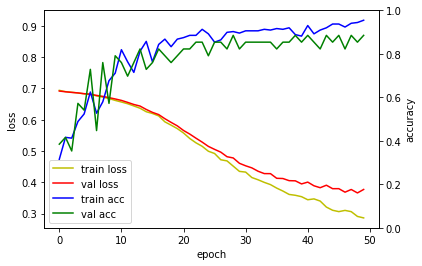

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 0.5145 - val_loss: 0.6930 - val_accuracy: 0.4783
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5821 - val_loss: 0.6911 - val_accuracy: 0.5870
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.6594 - val_loss: 0.6893 - val_accuracy: 0.6304
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.7271 - val_loss: 0.6876 - val_accuracy: 0.6739
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.7585 - val_loss: 0.6853 - val_accuracy: 0.6087
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.7826 - val_loss: 0.6826 - val_accuracy: 0.7609
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.7874 - val_loss: 0.6790 - val_accuracy: 0.7826
Epoch 8/

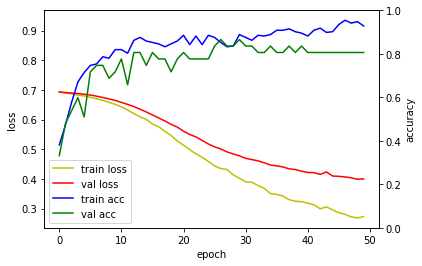

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6933 - accuracy: 0.4517 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5411 - val_loss: 0.6916 - val_accuracy: 0.5870
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.6377 - val_loss: 0.6902 - val_accuracy: 0.5870
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.6208 - val_loss: 0.6889 - val_accuracy: 0.5217
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5942 - val_loss: 0.6872 - val_accuracy: 0.5217
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6810 - accuracy: 0.6208 - val_loss: 0.6855 - val_accuracy: 0.5870
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.6594 - val_loss: 0.6837 - val_accuracy: 0.5435
Epoch 8/

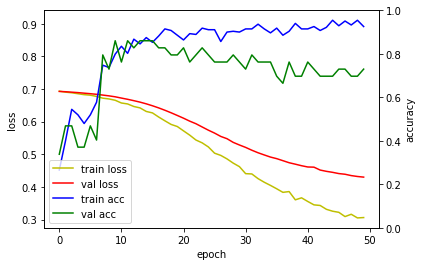

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.4903 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5362 - val_loss: 0.6904 - val_accuracy: 0.5870
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6232 - val_loss: 0.6881 - val_accuracy: 0.6739
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6840 - accuracy: 0.6908 - val_loss: 0.6857 - val_accuracy: 0.7609
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.6884 - val_loss: 0.6833 - val_accuracy: 0.8043
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6762 - accuracy: 0.7778 - val_loss: 0.6806 - val_accuracy: 0.8043
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.8164 - val_loss: 0.6765 - val_accuracy: 0.8261
Epoch 8/

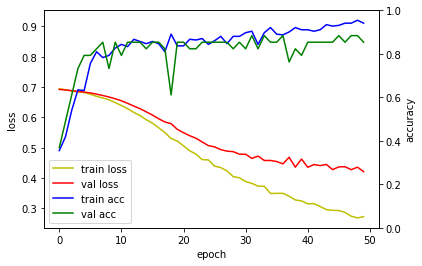

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6919 - accuracy: 0.5290 - val_loss: 0.6909 - val_accuracy: 0.5217
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.6401 - val_loss: 0.6882 - val_accuracy: 0.6522
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.6957 - val_loss: 0.6850 - val_accuracy: 0.7174
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.7029 - val_loss: 0.6815 - val_accuracy: 0.7826
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.7609 - val_loss: 0.6779 - val_accuracy: 0.7826
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.7633 - val_loss: 0.6728 - val_accuracy: 0.7826
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6689 - accuracy: 0.7029 - val_loss: 0.6681 - val_accuracy: 0.7826
Epoch 8/

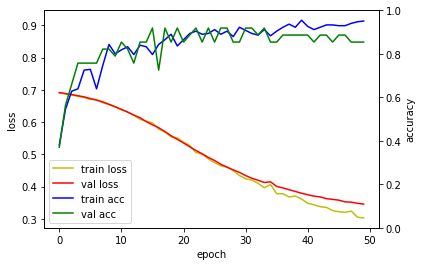

第4个：GATAAA
Epoch 1/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6970 - accuracy: 0.4686 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5169 - val_loss: 0.6924 - val_accuracy: 0.4783
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5531 - val_loss: 0.6919 - val_accuracy: 0.5217
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5918 - val_loss: 0.6908 - val_accuracy: 0.6304
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.6691 - val_loss: 0.6904 - val_accuracy: 0.5435
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.6401 - val_loss: 0.6890 - val_accuracy: 0.5652
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.7053 - val_loss: 0.6878 - val_accuracy: 0.6304
Epoch 8/

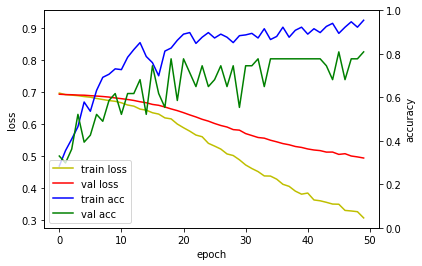

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 21ms/step - loss: 0.6935 - accuracy: 0.4975 - val_loss: 0.6920 - val_accuracy: 0.6269
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5788 - val_loss: 0.6905 - val_accuracy: 0.5373
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6285 - val_loss: 0.6891 - val_accuracy: 0.5970
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.6617 - val_loss: 0.6867 - val_accuracy: 0.6567
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.6567 - val_loss: 0.6842 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.6617 - val_loss: 0.6813 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.7529 - val_loss: 0.6778 - val_accuracy: 0.7164
Epoch 8/

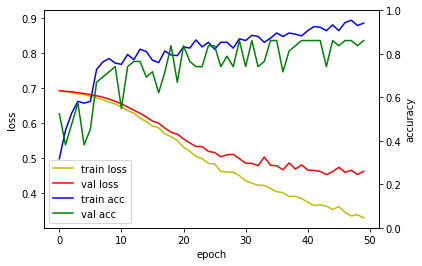

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6950 - accuracy: 0.4909 - val_loss: 0.6926 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5572 - val_loss: 0.6921 - val_accuracy: 0.5075
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5672 - val_loss: 0.6920 - val_accuracy: 0.5224
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5937 - val_loss: 0.6906 - val_accuracy: 0.5522
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.6650 - val_loss: 0.6891 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5804 - val_loss: 0.6880 - val_accuracy: 0.5522
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.7148 - val_loss: 0.6853 - val_accuracy: 0.6418
Epoch 8/5

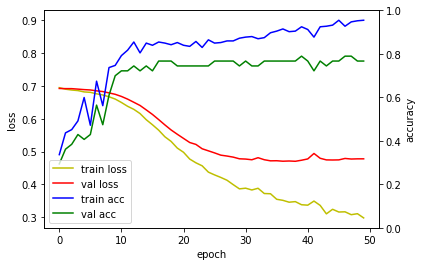

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6953 - accuracy: 0.4793 - val_loss: 0.6915 - val_accuracy: 0.5224
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5970 - val_loss: 0.6885 - val_accuracy: 0.6418
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.6335 - val_loss: 0.6844 - val_accuracy: 0.7015
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.6750 - val_loss: 0.6803 - val_accuracy: 0.7015
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.6484 - val_loss: 0.6758 - val_accuracy: 0.7164
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6650 - accuracy: 0.6700 - val_loss: 0.6681 - val_accuracy: 0.7164
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.7297 - val_loss: 0.6611 - val_accuracy: 0.7015
Epoch 8/5

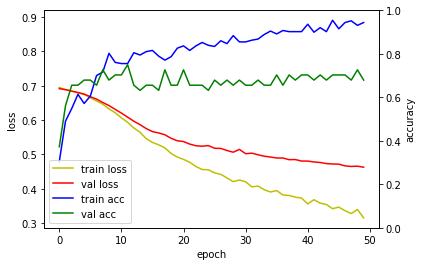

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6946 - accuracy: 0.4909 - val_loss: 0.6916 - val_accuracy: 0.4925
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5572 - val_loss: 0.6906 - val_accuracy: 0.5373
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5622 - val_loss: 0.6889 - val_accuracy: 0.5821
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.6202 - val_loss: 0.6880 - val_accuracy: 0.5075
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.6036 - val_loss: 0.6861 - val_accuracy: 0.5075
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.6169 - val_loss: 0.6849 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.6269 - val_loss: 0.6830 - val_accuracy: 0.5373
Epoch 8/5

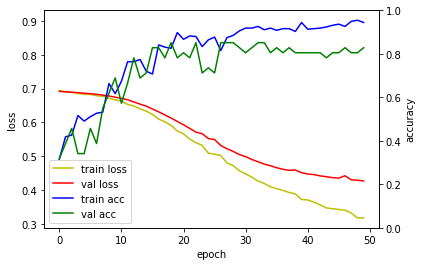

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.5041 - val_loss: 0.6901 - val_accuracy: 0.5970
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5771 - val_loss: 0.6887 - val_accuracy: 0.5821
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.6285 - val_loss: 0.6867 - val_accuracy: 0.5821
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.6584 - val_loss: 0.6835 - val_accuracy: 0.5970
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.6667 - val_loss: 0.6813 - val_accuracy: 0.6119
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6693 - accuracy: 0.6982 - val_loss: 0.6776 - val_accuracy: 0.6418
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6612 - accuracy: 0.7214 - val_loss: 0.6736 - val_accuracy: 0.5970
Epoch 8/5

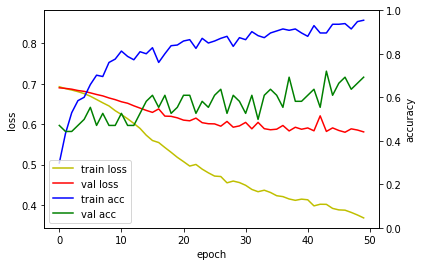

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6937 - accuracy: 0.4992 - val_loss: 0.6934 - val_accuracy: 0.5224
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5572 - val_loss: 0.6922 - val_accuracy: 0.5522
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5456 - val_loss: 0.6906 - val_accuracy: 0.4925
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.6186 - val_loss: 0.6892 - val_accuracy: 0.6716
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.6434 - val_loss: 0.6875 - val_accuracy: 0.7015
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.6899 - val_loss: 0.6849 - val_accuracy: 0.6866
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.7148 - val_loss: 0.6821 - val_accuracy: 0.7313
Epoch 8/5

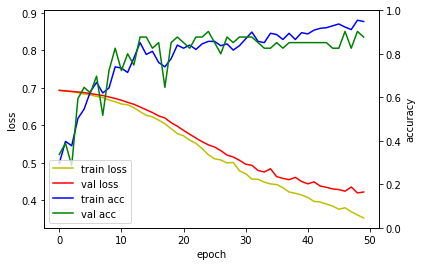

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6943 - accuracy: 0.5058 - val_loss: 0.6911 - val_accuracy: 0.4776
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5655 - val_loss: 0.6905 - val_accuracy: 0.5075
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5954 - val_loss: 0.6884 - val_accuracy: 0.6119
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.6517 - val_loss: 0.6868 - val_accuracy: 0.6269
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.6633 - val_loss: 0.6846 - val_accuracy: 0.6567
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.6949 - val_loss: 0.6822 - val_accuracy: 0.6567
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6685 - accuracy: 0.7148 - val_loss: 0.6792 - val_accuracy: 0.6567
Epoch 8/5

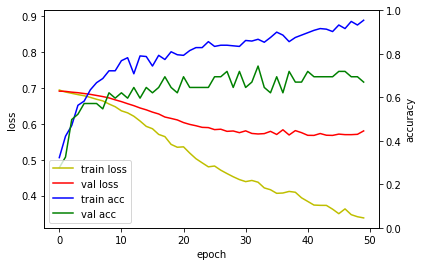

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6965 - accuracy: 0.4992 - val_loss: 0.6939 - val_accuracy: 0.4925
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5224 - val_loss: 0.6918 - val_accuracy: 0.5522
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.6119 - val_loss: 0.6915 - val_accuracy: 0.5970
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.6053 - val_loss: 0.6900 - val_accuracy: 0.5672
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.6235 - val_loss: 0.6879 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.6915 - val_loss: 0.6855 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.6833 - val_loss: 0.6818 - val_accuracy: 0.7313
Epoch 8/5

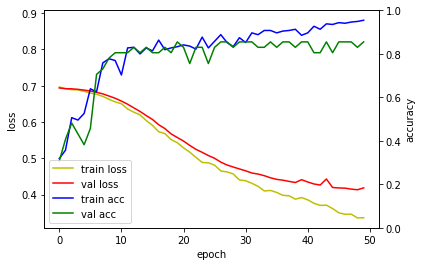

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.5058 - val_loss: 0.6913 - val_accuracy: 0.5224
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5622 - val_loss: 0.6912 - val_accuracy: 0.5373
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.6003 - val_loss: 0.6897 - val_accuracy: 0.5672
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5622 - val_loss: 0.6883 - val_accuracy: 0.5522
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.6119 - val_loss: 0.6866 - val_accuracy: 0.6418
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.7148 - val_loss: 0.6851 - val_accuracy: 0.5970
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.7247 - val_loss: 0.6813 - val_accuracy: 0.6418
Epoch 8/5

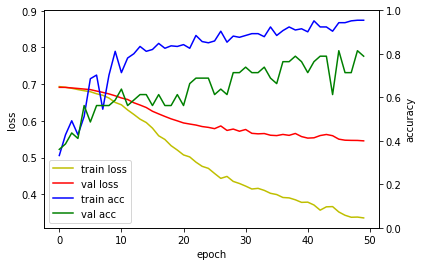

第5个：AGTAAA
Epoch 1/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.5224 - val_loss: 0.6898 - val_accuracy: 0.5821
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.6053 - val_loss: 0.6878 - val_accuracy: 0.5672
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.6401 - val_loss: 0.6849 - val_accuracy: 0.6866
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6915 - val_loss: 0.6810 - val_accuracy: 0.6119
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.7413 - val_loss: 0.6758 - val_accuracy: 0.7164
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.7728 - val_loss: 0.6696 - val_accuracy: 0.6866
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.7877 - val_loss: 0.6629 - val_accuracy: 0.6269
Epoch 8/5

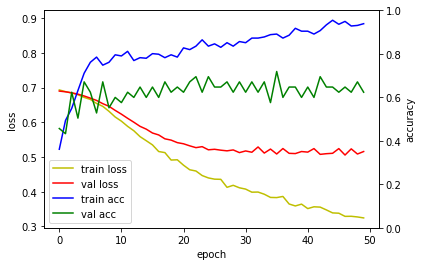

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.5362 - val_loss: 0.6892 - val_accuracy: 0.6957
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5926 - val_loss: 0.6831 - val_accuracy: 0.6377
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6924 - val_loss: 0.6762 - val_accuracy: 0.7101
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.7069 - val_loss: 0.6679 - val_accuracy: 0.6957
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.7295 - val_loss: 0.6570 - val_accuracy: 0.7536
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.7552 - val_loss: 0.6440 - val_accuracy: 0.7826
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.7520 - val_loss: 0.6315 - val_accuracy: 0.7536
Epoch 8/5

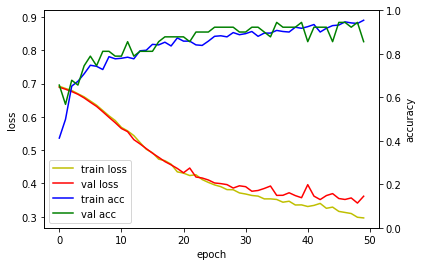

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.5588 - val_loss: 0.6909 - val_accuracy: 0.5797
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.6200 - val_loss: 0.6889 - val_accuracy: 0.6232
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.6490 - val_loss: 0.6867 - val_accuracy: 0.5362
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.6892 - val_loss: 0.6832 - val_accuracy: 0.5942
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.7262 - val_loss: 0.6808 - val_accuracy: 0.5507
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6828 - val_loss: 0.6780 - val_accuracy: 0.5507
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.7520 - val_loss: 0.6720 - val_accuracy: 0.6522
Epoch 8/5

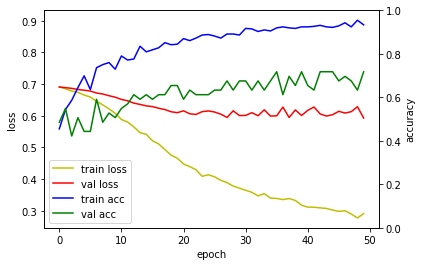

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.5024 - val_loss: 0.6915 - val_accuracy: 0.5072
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5539 - val_loss: 0.6899 - val_accuracy: 0.5797
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5523 - val_loss: 0.6878 - val_accuracy: 0.5652
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.7069 - val_loss: 0.6854 - val_accuracy: 0.6812
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.7037 - val_loss: 0.6824 - val_accuracy: 0.6667
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6689 - accuracy: 0.7391 - val_loss: 0.6787 - val_accuracy: 0.6957
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.7118 - val_loss: 0.6742 - val_accuracy: 0.6812
Epoch 8/5

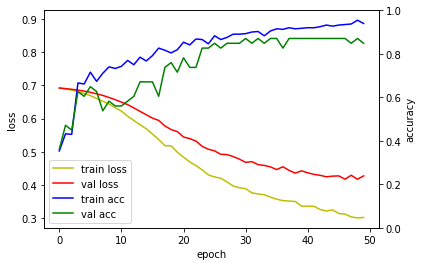

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6920 - accuracy: 0.4944 - val_loss: 0.6901 - val_accuracy: 0.4928
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5845 - val_loss: 0.6884 - val_accuracy: 0.5652
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.6103 - val_loss: 0.6853 - val_accuracy: 0.5942
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.6586 - val_loss: 0.6825 - val_accuracy: 0.6667
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.6876 - val_loss: 0.6787 - val_accuracy: 0.6377
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.6844 - val_loss: 0.6741 - val_accuracy: 0.5942
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6647 - accuracy: 0.6908 - val_loss: 0.6681 - val_accuracy: 0.6377
Epoch 8/5

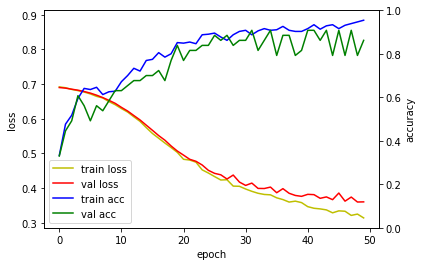

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6916 - accuracy: 0.5620 - val_loss: 0.6887 - val_accuracy: 0.6377
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.6312 - val_loss: 0.6824 - val_accuracy: 0.6812
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.6747 - val_loss: 0.6751 - val_accuracy: 0.6812
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6649 - accuracy: 0.7150 - val_loss: 0.6678 - val_accuracy: 0.7101
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6559 - accuracy: 0.7182 - val_loss: 0.6581 - val_accuracy: 0.6667
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.7311 - val_loss: 0.6486 - val_accuracy: 0.6957
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.7375 - val_loss: 0.6390 - val_accuracy: 0.7246
Epoch 8/5

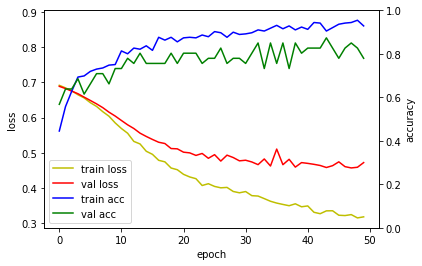

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6915 - accuracy: 0.5121 - val_loss: 0.6911 - val_accuracy: 0.5217
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.6006 - val_loss: 0.6860 - val_accuracy: 0.6812
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.6280 - val_loss: 0.6817 - val_accuracy: 0.7391
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.6747 - val_loss: 0.6776 - val_accuracy: 0.7101
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.7214 - val_loss: 0.6718 - val_accuracy: 0.7391
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.7424 - val_loss: 0.6648 - val_accuracy: 0.7101
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.7166 - val_loss: 0.6569 - val_accuracy: 0.7246
Epoch 8/5

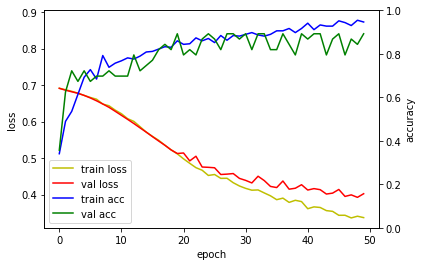

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6917 - accuracy: 0.4911 - val_loss: 0.6887 - val_accuracy: 0.5942
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.6151 - val_loss: 0.6855 - val_accuracy: 0.6522
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.6135 - val_loss: 0.6807 - val_accuracy: 0.6087
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.6747 - val_loss: 0.6761 - val_accuracy: 0.6087
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.6667 - val_loss: 0.6713 - val_accuracy: 0.6087
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.6570 - val_loss: 0.6653 - val_accuracy: 0.6522
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.7118 - val_loss: 0.6579 - val_accuracy: 0.6377
Epoch 8/5

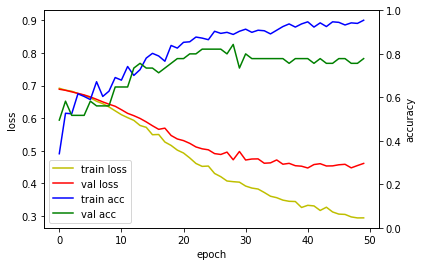

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6920 - accuracy: 0.5282 - val_loss: 0.6900 - val_accuracy: 0.6667
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5878 - val_loss: 0.6859 - val_accuracy: 0.6957
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.6377 - val_loss: 0.6810 - val_accuracy: 0.6812
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.6296 - val_loss: 0.6752 - val_accuracy: 0.6957
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.6876 - val_loss: 0.6686 - val_accuracy: 0.6957
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6715 - val_loss: 0.6591 - val_accuracy: 0.6957
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6828 - val_loss: 0.6498 - val_accuracy: 0.6812
Epoch 8/5

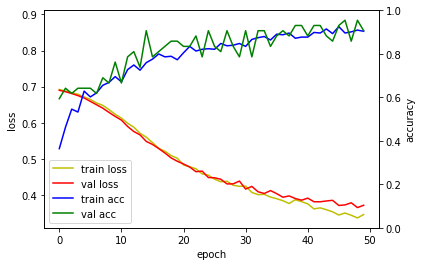

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5089 - val_loss: 0.6896 - val_accuracy: 0.5072
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5862 - val_loss: 0.6854 - val_accuracy: 0.6667
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.6248 - val_loss: 0.6817 - val_accuracy: 0.6812
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.6731 - val_loss: 0.6769 - val_accuracy: 0.6232
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.6570 - val_loss: 0.6719 - val_accuracy: 0.6232
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6957 - val_loss: 0.6658 - val_accuracy: 0.7536
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6579 - accuracy: 0.7134 - val_loss: 0.6581 - val_accuracy: 0.7536
Epoch 8/5

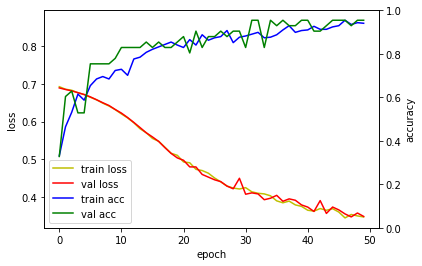

第6个：ACTAAA
Epoch 1/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6903 - accuracy: 0.5201 - val_loss: 0.6855 - val_accuracy: 0.5507
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.6570 - val_loss: 0.6769 - val_accuracy: 0.7391
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.7069 - val_loss: 0.6680 - val_accuracy: 0.7391
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.7440 - val_loss: 0.6583 - val_accuracy: 0.7391
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.7327 - val_loss: 0.6482 - val_accuracy: 0.7391
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.7601 - val_loss: 0.6362 - val_accuracy: 0.7391
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.7327 - val_loss: 0.6241 - val_accuracy: 0.7391
Epoch 8/5

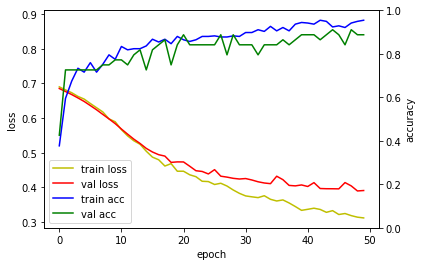

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.5085 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5783 - val_loss: 0.6898 - val_accuracy: 0.6795
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5698 - val_loss: 0.6874 - val_accuracy: 0.6923
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.6296 - val_loss: 0.6841 - val_accuracy: 0.7179
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6538 - val_loss: 0.6804 - val_accuracy: 0.7179
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.6880 - val_loss: 0.6761 - val_accuracy: 0.7179
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.7265 - val_loss: 0.6716 - val_accuracy: 0.6667
Epoch 8/5

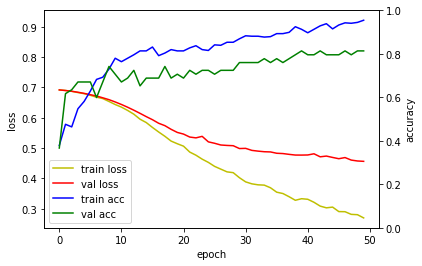

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.5157 - val_loss: 0.6913 - val_accuracy: 0.5897
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5356 - val_loss: 0.6903 - val_accuracy: 0.6154
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.6182 - val_loss: 0.6888 - val_accuracy: 0.6026
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.6111 - val_loss: 0.6867 - val_accuracy: 0.5641
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.6766 - val_loss: 0.6842 - val_accuracy: 0.6795
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.7023 - val_loss: 0.6817 - val_accuracy: 0.5897
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.7322 - val_loss: 0.6773 - val_accuracy: 0.6667
Epoch 8/5

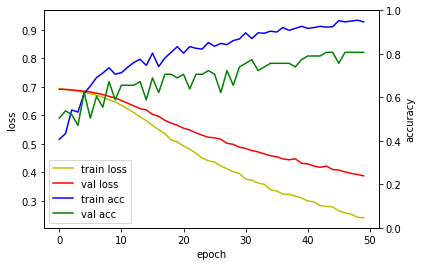

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.4972 - val_loss: 0.6899 - val_accuracy: 0.5256
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5940 - val_loss: 0.6867 - val_accuracy: 0.6410
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.6239 - val_loss: 0.6809 - val_accuracy: 0.5641
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.7151 - val_loss: 0.6759 - val_accuracy: 0.7564
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6671 - accuracy: 0.7464 - val_loss: 0.6689 - val_accuracy: 0.8205
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6866 - val_loss: 0.6599 - val_accuracy: 0.7949
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.7778 - val_loss: 0.6502 - val_accuracy: 0.7564
Epoch 8/5

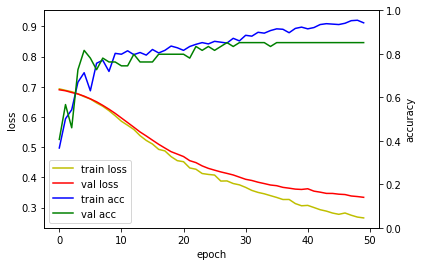

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5142 - val_loss: 0.6909 - val_accuracy: 0.5385
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5670 - val_loss: 0.6897 - val_accuracy: 0.5513
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.6838 - val_loss: 0.6879 - val_accuracy: 0.6667
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.6738 - val_loss: 0.6857 - val_accuracy: 0.5128
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.6638 - val_loss: 0.6828 - val_accuracy: 0.7692
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6695 - accuracy: 0.7094 - val_loss: 0.6795 - val_accuracy: 0.7949
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.7792 - val_loss: 0.6746 - val_accuracy: 0.8077
Epoch 8/5

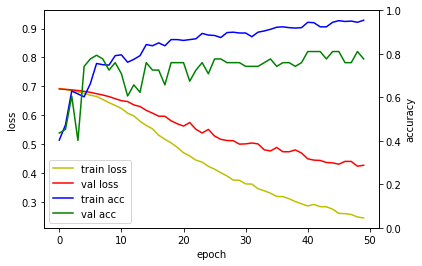

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5114 - val_loss: 0.6902 - val_accuracy: 0.6154
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5940 - val_loss: 0.6876 - val_accuracy: 0.6923
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.6325 - val_loss: 0.6842 - val_accuracy: 0.5641
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.6994 - val_loss: 0.6795 - val_accuracy: 0.7821
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.6852 - val_loss: 0.6744 - val_accuracy: 0.7949
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6538 - val_loss: 0.6685 - val_accuracy: 0.7949
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.7179 - val_loss: 0.6610 - val_accuracy: 0.7821
Epoch 8/5

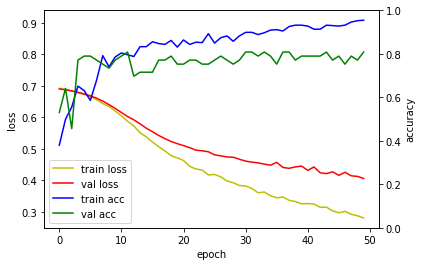

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.4972 - val_loss: 0.6930 - val_accuracy: 0.4744
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5484 - val_loss: 0.6900 - val_accuracy: 0.6410
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5470 - val_loss: 0.6875 - val_accuracy: 0.5256
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.6524 - val_loss: 0.6840 - val_accuracy: 0.6923
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6747 - accuracy: 0.7365 - val_loss: 0.6806 - val_accuracy: 0.6923
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.7464 - val_loss: 0.6755 - val_accuracy: 0.7436
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.7137 - val_loss: 0.6699 - val_accuracy: 0.7564
Epoch 8/5

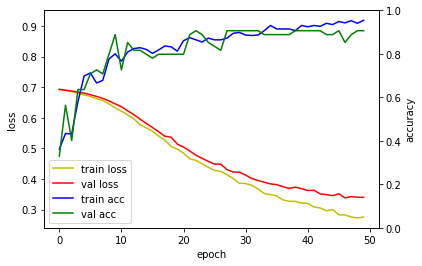

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 9ms/step - loss: 0.6937 - accuracy: 0.4986 - val_loss: 0.6921 - val_accuracy: 0.5641
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5897 - val_loss: 0.6907 - val_accuracy: 0.5769
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.6353 - val_loss: 0.6886 - val_accuracy: 0.5256
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.6524 - val_loss: 0.6866 - val_accuracy: 0.6923
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6785 - accuracy: 0.6781 - val_loss: 0.6842 - val_accuracy: 0.6667
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.7450 - val_loss: 0.6819 - val_accuracy: 0.6667
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.7422 - val_loss: 0.6786 - val_accuracy: 0.7179
Epoch 8/5

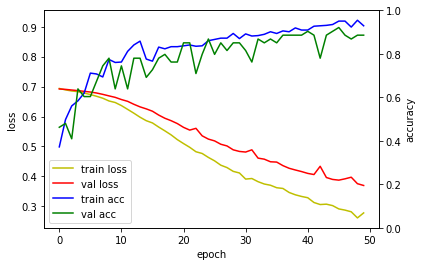

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.5157 - val_loss: 0.6900 - val_accuracy: 0.5641
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.6225 - val_loss: 0.6866 - val_accuracy: 0.6538
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.6681 - val_loss: 0.6819 - val_accuracy: 0.7051
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.6781 - val_loss: 0.6767 - val_accuracy: 0.7179
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6709 - accuracy: 0.6838 - val_loss: 0.6707 - val_accuracy: 0.6667
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.7407 - val_loss: 0.6633 - val_accuracy: 0.7564
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6564 - accuracy: 0.7607 - val_loss: 0.6546 - val_accuracy: 0.7821
Epoch 8/5

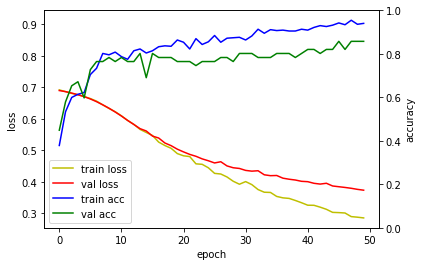

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4886 - val_loss: 0.6924 - val_accuracy: 0.5385
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5613 - val_loss: 0.6909 - val_accuracy: 0.5128
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.6168 - val_loss: 0.6889 - val_accuracy: 0.6923
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.6553 - val_loss: 0.6858 - val_accuracy: 0.6538
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.6254 - val_loss: 0.6842 - val_accuracy: 0.6538
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.7365 - val_loss: 0.6808 - val_accuracy: 0.7051
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.6838 - val_loss: 0.6768 - val_accuracy: 0.7949
Epoch 8/5

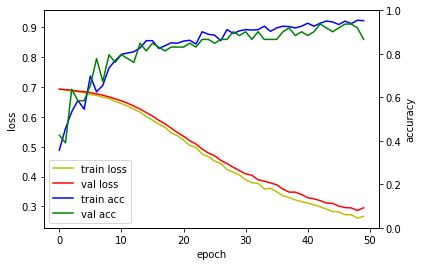

第7个：TATAAA
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.4972 - val_loss: 0.6938 - val_accuracy: 0.4744
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5798 - val_loss: 0.6916 - val_accuracy: 0.5897
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6368 - val_loss: 0.6904 - val_accuracy: 0.6026
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.6895 - val_loss: 0.6886 - val_accuracy: 0.5769
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.6752 - val_loss: 0.6864 - val_accuracy: 0.6026
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.7279 - val_loss: 0.6837 - val_accuracy: 0.6282
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.7236 - val_loss: 0.6805 - val_accuracy: 0.5897
Epoch 8/5

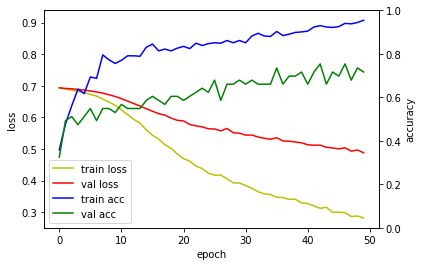

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 14ms/step - loss: 0.6855 - accuracy: 0.6162 - val_loss: 0.6736 - val_accuracy: 0.8295
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.7563 - val_loss: 0.6523 - val_accuracy: 0.7841
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.7891 - val_loss: 0.6261 - val_accuracy: 0.7614
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.7828 - val_loss: 0.5982 - val_accuracy: 0.7727
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5781 - accuracy: 0.7929 - val_loss: 0.5698 - val_accuracy: 0.7841
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5506 - accuracy: 0.7942 - val_loss: 0.5435 - val_accuracy: 0.8295
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5201 - accuracy: 0.8030 - val_loss: 0.5163 - val_accuracy: 0.8636
Epoch 8/

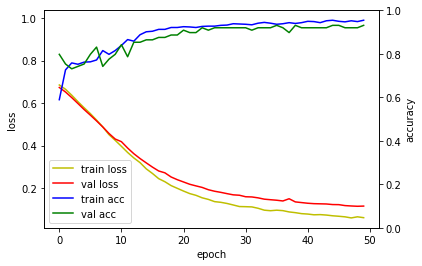

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6783 - accuracy: 0.7045 - val_loss: 0.6735 - val_accuracy: 0.7386
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.7778 - val_loss: 0.6526 - val_accuracy: 0.6705
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.8043 - val_loss: 0.6278 - val_accuracy: 0.7727
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5693 - accuracy: 0.8207 - val_loss: 0.6015 - val_accuracy: 0.7273
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5307 - accuracy: 0.8207 - val_loss: 0.5744 - val_accuracy: 0.6818
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4889 - accuracy: 0.8535 - val_loss: 0.5450 - val_accuracy: 0.7159
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4546 - accuracy: 0.8409 - val_loss: 0.5154 - val_accuracy: 0.7273
Epoch 8/5

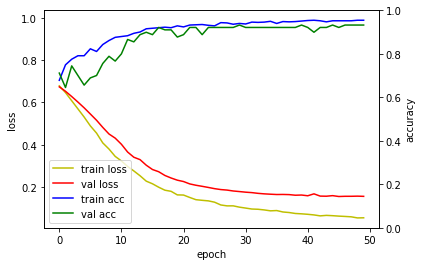

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6868 - accuracy: 0.6035 - val_loss: 0.6784 - val_accuracy: 0.7614
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6684 - accuracy: 0.7677 - val_loss: 0.6596 - val_accuracy: 0.7727
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.7879 - val_loss: 0.6375 - val_accuracy: 0.7727
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.7904 - val_loss: 0.6112 - val_accuracy: 0.7727
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.7955 - val_loss: 0.5835 - val_accuracy: 0.7727
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5668 - accuracy: 0.8005 - val_loss: 0.5533 - val_accuracy: 0.7727
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5349 - accuracy: 0.8030 - val_loss: 0.5216 - val_accuracy: 0.7727
Epoch 8/5

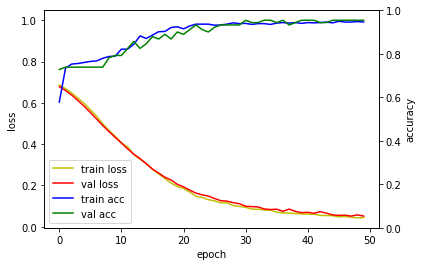

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6825 - accuracy: 0.6616 - val_loss: 0.6749 - val_accuracy: 0.6818
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.7639 - val_loss: 0.6542 - val_accuracy: 0.7614
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.7904 - val_loss: 0.6291 - val_accuracy: 0.7614
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6041 - accuracy: 0.8081 - val_loss: 0.5993 - val_accuracy: 0.7614
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5715 - accuracy: 0.8030 - val_loss: 0.5660 - val_accuracy: 0.7727
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5333 - accuracy: 0.8056 - val_loss: 0.5292 - val_accuracy: 0.7727
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4958 - accuracy: 0.8359 - val_loss: 0.4925 - val_accuracy: 0.8409
Epoch 8/5

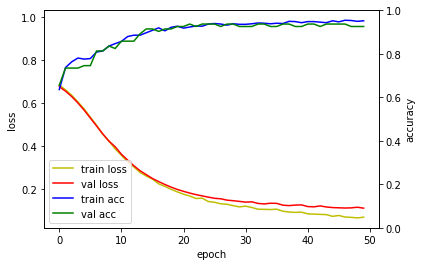

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6801 - accuracy: 0.6566 - val_loss: 0.6615 - val_accuracy: 0.8523
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.7765 - val_loss: 0.6281 - val_accuracy: 0.8409
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.7904 - val_loss: 0.5903 - val_accuracy: 0.8523
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5904 - accuracy: 0.8422 - val_loss: 0.5459 - val_accuracy: 0.8182
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5523 - accuracy: 0.8295 - val_loss: 0.5010 - val_accuracy: 0.8750
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5112 - accuracy: 0.8434 - val_loss: 0.4568 - val_accuracy: 0.9205
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4616 - accuracy: 0.8864 - val_loss: 0.4100 - val_accuracy: 0.9205
Epoch 8/5

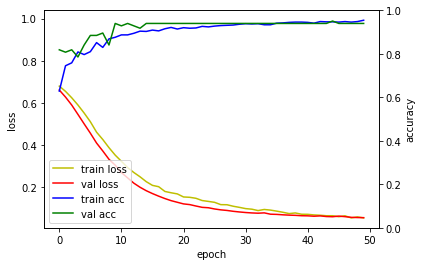

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6876 - accuracy: 0.6073 - val_loss: 0.6810 - val_accuracy: 0.8182
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.7222 - val_loss: 0.6636 - val_accuracy: 0.7841
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.7702 - val_loss: 0.6416 - val_accuracy: 0.7841
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.7891 - val_loss: 0.6179 - val_accuracy: 0.7955
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.8056 - val_loss: 0.5875 - val_accuracy: 0.7841
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5722 - accuracy: 0.7967 - val_loss: 0.5548 - val_accuracy: 0.7955
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.8106 - val_loss: 0.5221 - val_accuracy: 0.8182
Epoch 8/5

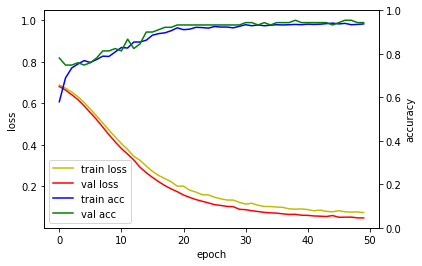

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6873 - accuracy: 0.5896 - val_loss: 0.6763 - val_accuracy: 0.7727
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.7487 - val_loss: 0.6572 - val_accuracy: 0.8295
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.7929 - val_loss: 0.6336 - val_accuracy: 0.8295
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.8005 - val_loss: 0.6060 - val_accuracy: 0.8068
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5977 - accuracy: 0.7790 - val_loss: 0.5767 - val_accuracy: 0.8068
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5706 - accuracy: 0.8043 - val_loss: 0.5460 - val_accuracy: 0.8068
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5412 - accuracy: 0.7917 - val_loss: 0.5210 - val_accuracy: 0.8636
Epoch 8/5

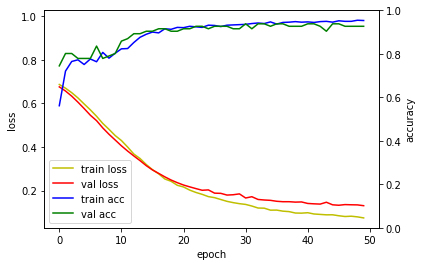

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.6880 - accuracy: 0.6250 - val_loss: 0.6837 - val_accuracy: 0.7273
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6714 - accuracy: 0.7323 - val_loss: 0.6666 - val_accuracy: 0.7614
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.7816 - val_loss: 0.6421 - val_accuracy: 0.7614
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6126 - accuracy: 0.8157 - val_loss: 0.6096 - val_accuracy: 0.7614
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5715 - accuracy: 0.8043 - val_loss: 0.5731 - val_accuracy: 0.7614
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5299 - accuracy: 0.8258 - val_loss: 0.5376 - val_accuracy: 0.7614
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4905 - accuracy: 0.8068 - val_loss: 0.5018 - val_accuracy: 0.7955
Epoch 8/5

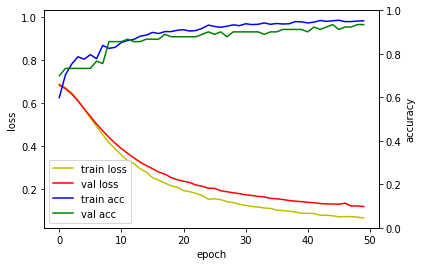

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6840 - accuracy: 0.5720 - val_loss: 0.6679 - val_accuracy: 0.7727
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6592 - accuracy: 0.7487 - val_loss: 0.6372 - val_accuracy: 0.8523
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.8030 - val_loss: 0.5992 - val_accuracy: 0.8409
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5915 - accuracy: 0.8106 - val_loss: 0.5574 - val_accuracy: 0.8636
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5519 - accuracy: 0.8422 - val_loss: 0.5147 - val_accuracy: 0.8523
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5112 - accuracy: 0.8434 - val_loss: 0.4717 - val_accuracy: 0.8636
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4742 - accuracy: 0.8422 - val_loss: 0.4366 - val_accuracy: 0.9545
Epoch 8/5

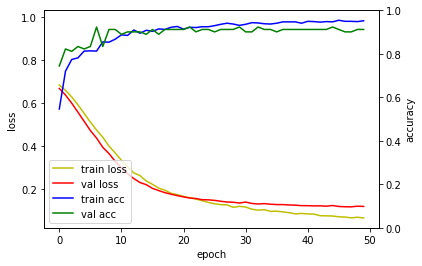

第8个：AATACA
Epoch 1/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6847 - accuracy: 0.5657 - val_loss: 0.6722 - val_accuracy: 0.7955
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.7235 - val_loss: 0.6515 - val_accuracy: 0.8523
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.7753 - val_loss: 0.6249 - val_accuracy: 0.8636
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.7753 - val_loss: 0.5942 - val_accuracy: 0.8636
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5917 - accuracy: 0.8119 - val_loss: 0.5582 - val_accuracy: 0.8636
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5606 - accuracy: 0.7879 - val_loss: 0.5190 - val_accuracy: 0.8636
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5256 - accuracy: 0.8144 - val_loss: 0.4812 - val_accuracy: 0.8750
Epoch 8/5

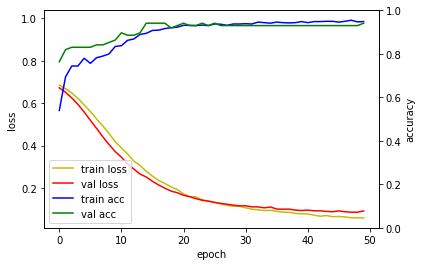

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 11ms/step - loss: 0.6789 - accuracy: 0.5854 - val_loss: 0.6664 - val_accuracy: 0.6992
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.7416 - val_loss: 0.6364 - val_accuracy: 0.7073
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.7353 - val_loss: 0.6025 - val_accuracy: 0.7805
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5781 - accuracy: 0.7624 - val_loss: 0.5640 - val_accuracy: 0.7886
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5370 - accuracy: 0.8013 - val_loss: 0.5293 - val_accuracy: 0.7317
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4936 - accuracy: 0.8076 - val_loss: 0.4873 - val_accuracy: 0.7967
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4603 - accuracy: 0.8193 - val_loss: 0.4514 - val_accuracy: 0.8211
Epoch 8/

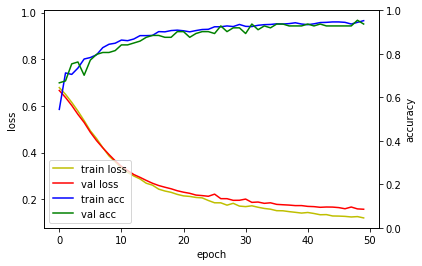

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.5610 - val_loss: 0.6741 - val_accuracy: 0.6911
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.7209 - val_loss: 0.6484 - val_accuracy: 0.7480
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.7832 - val_loss: 0.6151 - val_accuracy: 0.8130
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5959 - accuracy: 0.7949 - val_loss: 0.5762 - val_accuracy: 0.8211
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5534 - accuracy: 0.8184 - val_loss: 0.5339 - val_accuracy: 0.8293
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5155 - accuracy: 0.8338 - val_loss: 0.4961 - val_accuracy: 0.7967
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4681 - accuracy: 0.8546 - val_loss: 0.4543 - val_accuracy: 0.8537
Epoch 8/5

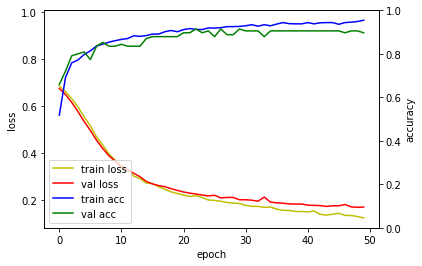

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 6ms/step - loss: 0.6804 - accuracy: 0.6170 - val_loss: 0.6688 - val_accuracy: 0.7236
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6545 - accuracy: 0.7236 - val_loss: 0.6421 - val_accuracy: 0.6829
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.7227 - val_loss: 0.6100 - val_accuracy: 0.7073
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5860 - accuracy: 0.7724 - val_loss: 0.5791 - val_accuracy: 0.6667
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5489 - accuracy: 0.7886 - val_loss: 0.5328 - val_accuracy: 0.8293
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5065 - accuracy: 0.8293 - val_loss: 0.5022 - val_accuracy: 0.7236
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4696 - accuracy: 0.8329 - val_loss: 0.4536 - val_accuracy: 0.8374
Epoch 8/5

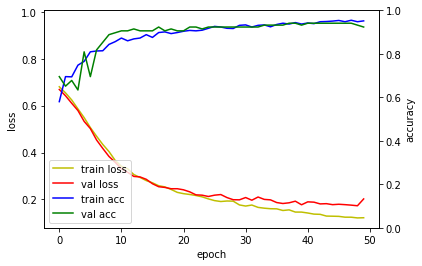

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6810 - accuracy: 0.6233 - val_loss: 0.6734 - val_accuracy: 0.6504
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.7073 - val_loss: 0.6522 - val_accuracy: 0.6585
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6965 - val_loss: 0.6310 - val_accuracy: 0.6585
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6040 - accuracy: 0.7227 - val_loss: 0.6104 - val_accuracy: 0.6585
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5764 - accuracy: 0.7335 - val_loss: 0.5882 - val_accuracy: 0.7154
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5427 - accuracy: 0.7669 - val_loss: 0.5670 - val_accuracy: 0.7236
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5165 - accuracy: 0.7778 - val_loss: 0.5450 - val_accuracy: 0.7480
Epoch 8/5

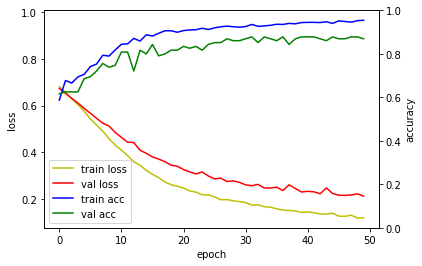

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6805 - accuracy: 0.5854 - val_loss: 0.6611 - val_accuracy: 0.7317
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.7344 - val_loss: 0.6323 - val_accuracy: 0.7154
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.7760 - val_loss: 0.5986 - val_accuracy: 0.7724
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5779 - accuracy: 0.7841 - val_loss: 0.5622 - val_accuracy: 0.7967
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5329 - accuracy: 0.8410 - val_loss: 0.5229 - val_accuracy: 0.7967
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4893 - accuracy: 0.8410 - val_loss: 0.4849 - val_accuracy: 0.8211
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4513 - accuracy: 0.8410 - val_loss: 0.4535 - val_accuracy: 0.8211
Epoch 8/5

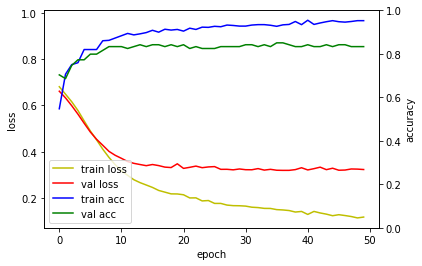

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6881 - accuracy: 0.5818 - val_loss: 0.6825 - val_accuracy: 0.6260
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6702 - accuracy: 0.7001 - val_loss: 0.6670 - val_accuracy: 0.6179
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6893 - val_loss: 0.6469 - val_accuracy: 0.6423
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.7136 - val_loss: 0.6219 - val_accuracy: 0.6341
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5900 - accuracy: 0.7272 - val_loss: 0.5923 - val_accuracy: 0.7642
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5572 - accuracy: 0.7814 - val_loss: 0.5608 - val_accuracy: 0.8211
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5175 - accuracy: 0.8040 - val_loss: 0.5260 - val_accuracy: 0.8211
Epoch 8/5

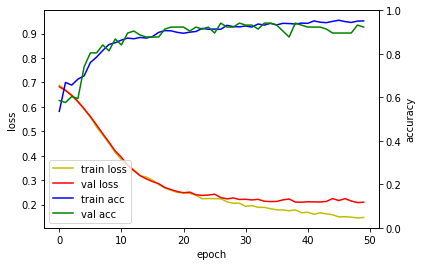

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6828 - accuracy: 0.5890 - val_loss: 0.6717 - val_accuracy: 0.6911
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6631 - accuracy: 0.6965 - val_loss: 0.6501 - val_accuracy: 0.7154
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.7236 - val_loss: 0.6244 - val_accuracy: 0.7317
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.7191 - val_loss: 0.5934 - val_accuracy: 0.7398
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5760 - accuracy: 0.7606 - val_loss: 0.5647 - val_accuracy: 0.6829
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5435 - accuracy: 0.7678 - val_loss: 0.5279 - val_accuracy: 0.7724
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5121 - accuracy: 0.7931 - val_loss: 0.4955 - val_accuracy: 0.8211
Epoch 8/5

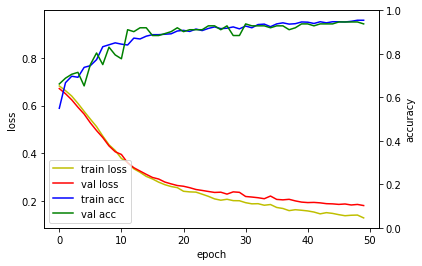

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.6107 - val_loss: 0.6704 - val_accuracy: 0.7724
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6592 - accuracy: 0.7272 - val_loss: 0.6413 - val_accuracy: 0.7317
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.7371 - val_loss: 0.6082 - val_accuracy: 0.7480
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5973 - accuracy: 0.7435 - val_loss: 0.5689 - val_accuracy: 0.7561
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5651 - accuracy: 0.7489 - val_loss: 0.5302 - val_accuracy: 0.7480
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5248 - accuracy: 0.7615 - val_loss: 0.4923 - val_accuracy: 0.8293
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4913 - accuracy: 0.8004 - val_loss: 0.4616 - val_accuracy: 0.8211
Epoch 8/5

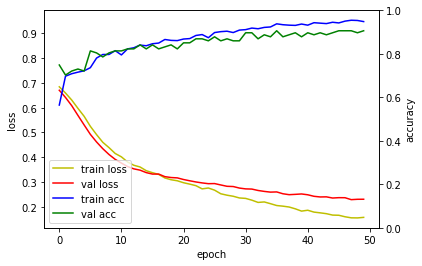

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6831 - accuracy: 0.6387 - val_loss: 0.6707 - val_accuracy: 0.7154
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.7127 - val_loss: 0.6425 - val_accuracy: 0.7154
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.7471 - val_loss: 0.6067 - val_accuracy: 0.8049
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5847 - accuracy: 0.8031 - val_loss: 0.5618 - val_accuracy: 0.7886
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5380 - accuracy: 0.8175 - val_loss: 0.5101 - val_accuracy: 0.8699
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4876 - accuracy: 0.8509 - val_loss: 0.4571 - val_accuracy: 0.8537
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4394 - accuracy: 0.8735 - val_loss: 0.4101 - val_accuracy: 0.8943
Epoch 8/5

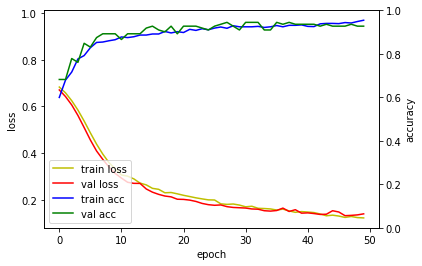

第9个：AAAAAG
Epoch 1/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6805 - accuracy: 0.6640 - val_loss: 0.6690 - val_accuracy: 0.7805
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6562 - accuracy: 0.7561 - val_loss: 0.6435 - val_accuracy: 0.7642
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.7525 - val_loss: 0.6119 - val_accuracy: 0.8211
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5905 - accuracy: 0.8085 - val_loss: 0.5759 - val_accuracy: 0.7967
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5526 - accuracy: 0.8022 - val_loss: 0.5379 - val_accuracy: 0.8211
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.5075 - accuracy: 0.8329 - val_loss: 0.5015 - val_accuracy: 0.8049
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4645 - accuracy: 0.8591 - val_loss: 0.4662 - val_accuracy: 0.8049
Epoch 8/5

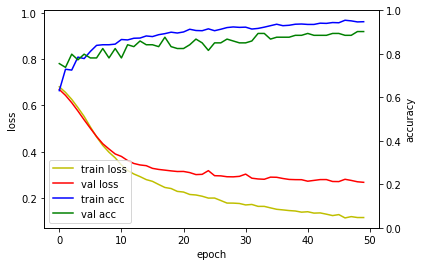

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 11ms/step - loss: 0.6929 - accuracy: 0.5156 - val_loss: 0.6895 - val_accuracy: 0.6160
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6320 - val_loss: 0.6853 - val_accuracy: 0.5840
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.6427 - val_loss: 0.6793 - val_accuracy: 0.5840
Epoch 4/50
36/36 [==============================] - 0s 5ms/step - loss: 0.6708 - accuracy: 0.6400 - val_loss: 0.6710 - val_accuracy: 0.8000
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.7609 - val_loss: 0.6608 - val_accuracy: 0.7440
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.7662 - val_loss: 0.6471 - val_accuracy: 0.7840
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.7787 - val_loss: 0.6316 - val_accuracy: 0.7440
Epoch 8

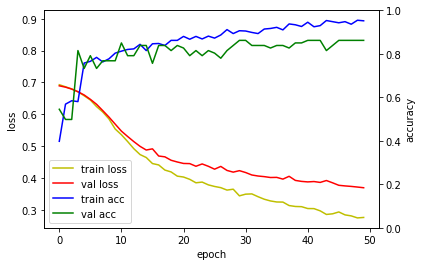

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.5262 - val_loss: 0.6888 - val_accuracy: 0.6240
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5911 - val_loss: 0.6838 - val_accuracy: 0.6560
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.6258 - val_loss: 0.6788 - val_accuracy: 0.5840
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6773 - val_loss: 0.6694 - val_accuracy: 0.6560
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.7253 - val_loss: 0.6588 - val_accuracy: 0.6640
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.7724 - val_loss: 0.6447 - val_accuracy: 0.7120
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.7689 - val_loss: 0.6285 - val_accuracy: 0.6960
Epoch 8/

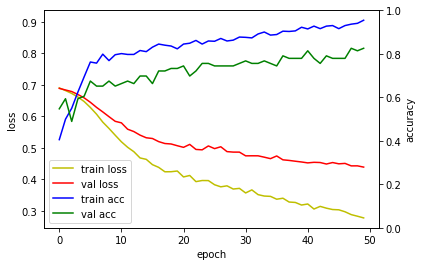

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5013 - val_loss: 0.6897 - val_accuracy: 0.5360
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5733 - val_loss: 0.6857 - val_accuracy: 0.6400
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.5582 - val_loss: 0.6814 - val_accuracy: 0.5280
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.6667 - val_loss: 0.6743 - val_accuracy: 0.7440
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.6960 - val_loss: 0.6654 - val_accuracy: 0.7040
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.7324 - val_loss: 0.6537 - val_accuracy: 0.7280
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.7280 - val_loss: 0.6390 - val_accuracy: 0.7680
Epoch 8/

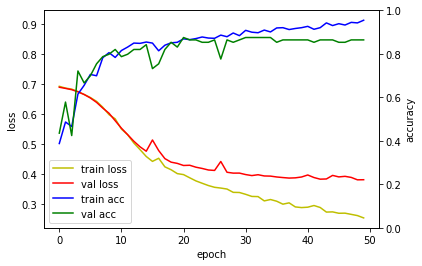

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5218 - val_loss: 0.6883 - val_accuracy: 0.5760
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5991 - val_loss: 0.6820 - val_accuracy: 0.5200
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.6551 - val_loss: 0.6727 - val_accuracy: 0.7200
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.6311 - val_loss: 0.6633 - val_accuracy: 0.7440
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.7173 - val_loss: 0.6514 - val_accuracy: 0.7200
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.7342 - val_loss: 0.6325 - val_accuracy: 0.7520
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.7849 - val_loss: 0.6101 - val_accuracy: 0.7360
Epoch 8/

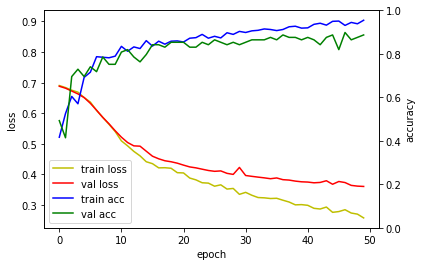

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5502 - val_loss: 0.6877 - val_accuracy: 0.5920
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5938 - val_loss: 0.6816 - val_accuracy: 0.6480
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.6258 - val_loss: 0.6737 - val_accuracy: 0.7120
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.7316 - val_loss: 0.6618 - val_accuracy: 0.7280
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.7404 - val_loss: 0.6449 - val_accuracy: 0.8080
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.7538 - val_loss: 0.6266 - val_accuracy: 0.7120
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.7893 - val_loss: 0.5999 - val_accuracy: 0.8320
Epoch 8/

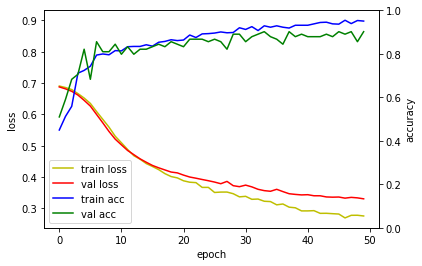

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5067 - val_loss: 0.6884 - val_accuracy: 0.5440
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5609 - val_loss: 0.6852 - val_accuracy: 0.7280
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.6391 - val_loss: 0.6800 - val_accuracy: 0.6720
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.6933 - val_loss: 0.6692 - val_accuracy: 0.8240
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6622 - accuracy: 0.7769 - val_loss: 0.6566 - val_accuracy: 0.8480
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.7538 - val_loss: 0.6401 - val_accuracy: 0.8560
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.7458 - val_loss: 0.6267 - val_accuracy: 0.7040
Epoch 8/

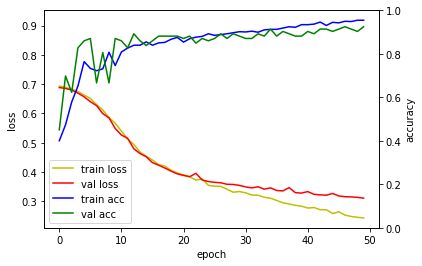

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5076 - val_loss: 0.6901 - val_accuracy: 0.5680
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5858 - val_loss: 0.6854 - val_accuracy: 0.6000
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.6160 - val_loss: 0.6786 - val_accuracy: 0.7360
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6681 - accuracy: 0.6907 - val_loss: 0.6703 - val_accuracy: 0.7040
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.7716 - val_loss: 0.6592 - val_accuracy: 0.7360
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.7236 - val_loss: 0.6474 - val_accuracy: 0.7200
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.7876 - val_loss: 0.6310 - val_accuracy: 0.7280
Epoch 8/

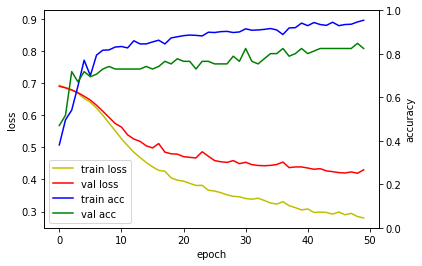

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5120 - val_loss: 0.6882 - val_accuracy: 0.6560
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.6098 - val_loss: 0.6817 - val_accuracy: 0.7200
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.6364 - val_loss: 0.6750 - val_accuracy: 0.6480
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6709 - accuracy: 0.6773 - val_loss: 0.6640 - val_accuracy: 0.8240
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.7298 - val_loss: 0.6481 - val_accuracy: 0.7680
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.7591 - val_loss: 0.6307 - val_accuracy: 0.7920
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.7529 - val_loss: 0.6045 - val_accuracy: 0.7920
Epoch 8/

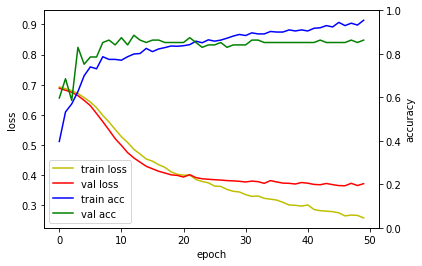

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5413 - val_loss: 0.6873 - val_accuracy: 0.6560
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.6178 - val_loss: 0.6810 - val_accuracy: 0.6640
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.6791 - val_loss: 0.6726 - val_accuracy: 0.6400
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.6898 - val_loss: 0.6582 - val_accuracy: 0.7200
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.7271 - val_loss: 0.6402 - val_accuracy: 0.7200
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.7369 - val_loss: 0.6218 - val_accuracy: 0.7440
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6015 - accuracy: 0.7609 - val_loss: 0.6034 - val_accuracy: 0.7440
Epoch 8/

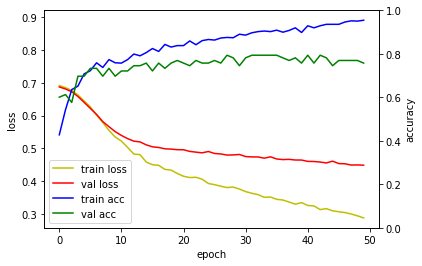

第10个：AAGAAA
Epoch 1/50
36/36 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5262 - val_loss: 0.6892 - val_accuracy: 0.6080
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.6222 - val_loss: 0.6840 - val_accuracy: 0.7040
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.6818 - val_loss: 0.6778 - val_accuracy: 0.6960
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6728 - accuracy: 0.6960 - val_loss: 0.6678 - val_accuracy: 0.7520
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6622 - accuracy: 0.7022 - val_loss: 0.6549 - val_accuracy: 0.7520
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.7316 - val_loss: 0.6385 - val_accuracy: 0.7520
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.7716 - val_loss: 0.6218 - val_accuracy: 0.7200
Epoch 8/

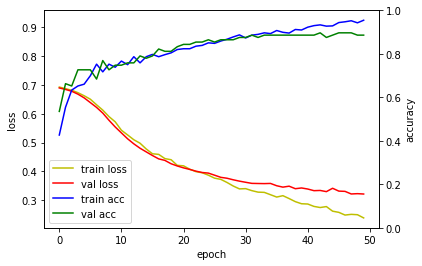

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.5148 - val_loss: 0.6875 - val_accuracy: 0.5208
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5995 - val_loss: 0.6779 - val_accuracy: 0.5208
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.6819 - val_loss: 0.6636 - val_accuracy: 0.5750
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6681 - val_loss: 0.6432 - val_accuracy: 0.6875
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.7630 - val_loss: 0.6094 - val_accuracy: 0.7958
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5837 - accuracy: 0.7954 - val_loss: 0.5728 - val_accuracy: 0.7667
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5449 - accuracy: 0.7907 - val_loss: 0.5342 - val_accuracy: 0.7792
Epoch 8/

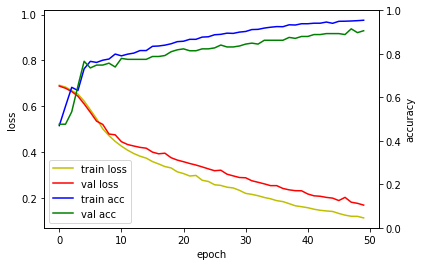

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5366 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.6208 - val_loss: 0.6715 - val_accuracy: 0.5833
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6926 - val_loss: 0.6403 - val_accuracy: 0.7542
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.7769 - val_loss: 0.5978 - val_accuracy: 0.7875
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5741 - accuracy: 0.7852 - val_loss: 0.5517 - val_accuracy: 0.7958
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5331 - accuracy: 0.7852 - val_loss: 0.5135 - val_accuracy: 0.8000
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.4965 - accuracy: 0.7875 - val_loss: 0.4837 - val_accuracy: 0.8000
Epoch 8/

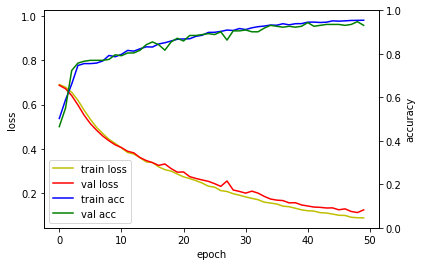

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5509 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.6671 - val_loss: 0.6668 - val_accuracy: 0.8000
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.7574 - val_loss: 0.6404 - val_accuracy: 0.7750
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.7574 - val_loss: 0.6041 - val_accuracy: 0.7875
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5825 - accuracy: 0.7875 - val_loss: 0.5605 - val_accuracy: 0.7917
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5441 - accuracy: 0.7931 - val_loss: 0.5109 - val_accuracy: 0.8458
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5013 - accuracy: 0.8250 - val_loss: 0.4686 - val_accuracy: 0.8667
Epoch 8/

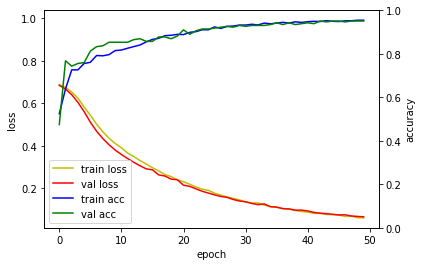

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.6032 - val_loss: 0.6763 - val_accuracy: 0.6708
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.7088 - val_loss: 0.6512 - val_accuracy: 0.8167
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.7565 - val_loss: 0.6097 - val_accuracy: 0.8042
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5908 - accuracy: 0.7694 - val_loss: 0.5586 - val_accuracy: 0.8000
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5406 - accuracy: 0.7889 - val_loss: 0.5110 - val_accuracy: 0.8000
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.7963 - val_loss: 0.4760 - val_accuracy: 0.8125
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.4685 - accuracy: 0.8014 - val_loss: 0.4536 - val_accuracy: 0.8125
Epoch 8/

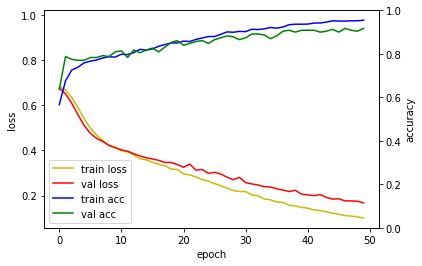

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5440 - val_loss: 0.6840 - val_accuracy: 0.5500
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.6769 - val_loss: 0.6656 - val_accuracy: 0.7667
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.7713 - val_loss: 0.6376 - val_accuracy: 0.7292
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.7593 - val_loss: 0.5996 - val_accuracy: 0.7833
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5674 - accuracy: 0.8194 - val_loss: 0.5657 - val_accuracy: 0.7542
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5274 - accuracy: 0.8139 - val_loss: 0.5180 - val_accuracy: 0.8042
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.4882 - accuracy: 0.8296 - val_loss: 0.4859 - val_accuracy: 0.8000
Epoch 8/

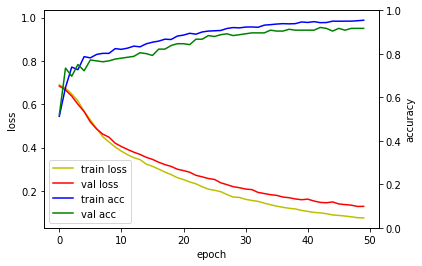

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5292 - val_loss: 0.6902 - val_accuracy: 0.6208
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.6407 - val_loss: 0.6825 - val_accuracy: 0.6542
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.6884 - val_loss: 0.6713 - val_accuracy: 0.7167
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6534 - accuracy: 0.7315 - val_loss: 0.6506 - val_accuracy: 0.7625
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.7532 - val_loss: 0.6195 - val_accuracy: 0.8208
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5836 - accuracy: 0.8069 - val_loss: 0.5751 - val_accuracy: 0.8292
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5414 - accuracy: 0.8106 - val_loss: 0.5305 - val_accuracy: 0.8167
Epoch 8/

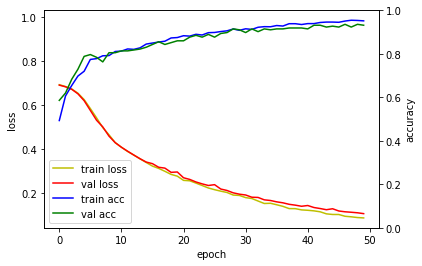

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5491 - val_loss: 0.6851 - val_accuracy: 0.5083
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.6597 - val_loss: 0.6718 - val_accuracy: 0.7125
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.7366 - val_loss: 0.6510 - val_accuracy: 0.6500
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.7708 - val_loss: 0.6137 - val_accuracy: 0.7583
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5793 - accuracy: 0.7731 - val_loss: 0.5767 - val_accuracy: 0.7583
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5354 - accuracy: 0.7861 - val_loss: 0.5456 - val_accuracy: 0.7500
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.4957 - accuracy: 0.7963 - val_loss: 0.5179 - val_accuracy: 0.7625
Epoch 8/

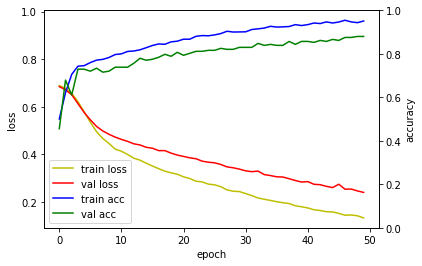

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5245 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5667 - val_loss: 0.6829 - val_accuracy: 0.6042
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.6741 - val_loss: 0.6706 - val_accuracy: 0.6958
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.7060 - val_loss: 0.6552 - val_accuracy: 0.7583
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.7218 - val_loss: 0.6372 - val_accuracy: 0.6875
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.7292 - val_loss: 0.6125 - val_accuracy: 0.7000
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5769 - accuracy: 0.7611 - val_loss: 0.5858 - val_accuracy: 0.7458
Epoch 8/

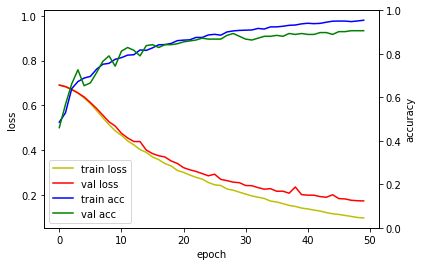

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5611 - val_loss: 0.6843 - val_accuracy: 0.6042
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6785 - accuracy: 0.6653 - val_loss: 0.6723 - val_accuracy: 0.5667
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6616 - accuracy: 0.7454 - val_loss: 0.6499 - val_accuracy: 0.8417
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.7903 - val_loss: 0.6158 - val_accuracy: 0.8208
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5925 - accuracy: 0.8028 - val_loss: 0.5705 - val_accuracy: 0.8458
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5468 - accuracy: 0.8255 - val_loss: 0.5200 - val_accuracy: 0.8667
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.4994 - accuracy: 0.8431 - val_loss: 0.4724 - val_accuracy: 0.8667
Epoch 8/

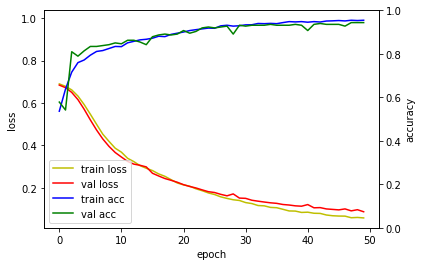

第11个：ATTAAA
Epoch 1/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5921 - val_loss: 0.6797 - val_accuracy: 0.6667
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6661 - accuracy: 0.7176 - val_loss: 0.6540 - val_accuracy: 0.6917
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.7366 - val_loss: 0.6169 - val_accuracy: 0.7625
Epoch 4/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5884 - accuracy: 0.7560 - val_loss: 0.5802 - val_accuracy: 0.7000
Epoch 5/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5508 - accuracy: 0.7519 - val_loss: 0.5405 - val_accuracy: 0.7583
Epoch 6/50
68/68 [==============================] - 0s 4ms/step - loss: 0.5166 - accuracy: 0.7657 - val_loss: 0.5124 - val_accuracy: 0.7458
Epoch 7/50
68/68 [==============================] - 0s 4ms/step - loss: 0.4911 - accuracy: 0.7815 - val_loss: 0.4907 - val_accuracy: 0.7750
Epoch 8/

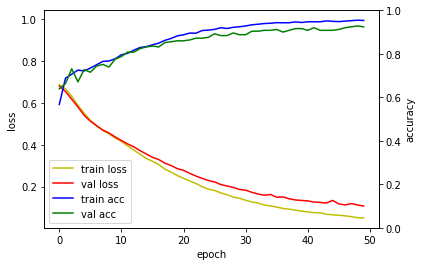

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 5ms/step - loss: 0.6898 - accuracy: 0.5406 - val_loss: 0.6844 - val_accuracy: 0.5241
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6732 - accuracy: 0.6521 - val_loss: 0.6578 - val_accuracy: 0.7437
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6332 - accuracy: 0.7076 - val_loss: 0.6144 - val_accuracy: 0.6994
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5773 - accuracy: 0.7405 - val_loss: 0.5668 - val_accuracy: 0.7514
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5370 - accuracy: 0.7547 - val_loss: 0.5521 - val_accuracy: 0.7033
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5124 - accuracy: 0.7722 - val_loss: 0.5296 - val_accuracy: 0.7534
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.4942 - accuracy: 0.7737 - val_loss: 0.5196 - val_accuracy: 0

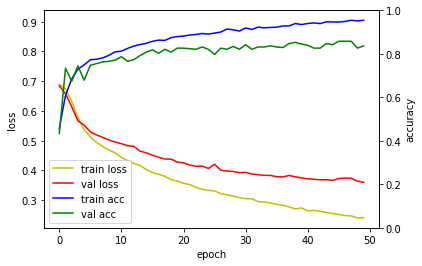

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6839 - accuracy: 0.5772 - val_loss: 0.6708 - val_accuracy: 0.7013
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6411 - accuracy: 0.7007 - val_loss: 0.6174 - val_accuracy: 0.7264
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5817 - accuracy: 0.7288 - val_loss: 0.5757 - val_accuracy: 0.7399
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5424 - accuracy: 0.7305 - val_loss: 0.5600 - val_accuracy: 0.7283
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5233 - accuracy: 0.7472 - val_loss: 0.5509 - val_accuracy: 0.7360
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5105 - accuracy: 0.7536 - val_loss: 0.5461 - val_accuracy: 0.7283
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5027 - accuracy: 0.7557 - val_loss: 0.5424 - val_accuracy: 0

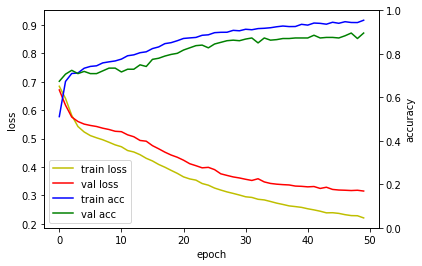

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6769 - accuracy: 0.6069 - val_loss: 0.6529 - val_accuracy: 0.7495
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6277 - accuracy: 0.6962 - val_loss: 0.5998 - val_accuracy: 0.7052
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5793 - accuracy: 0.7213 - val_loss: 0.5587 - val_accuracy: 0.7283
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5496 - accuracy: 0.7337 - val_loss: 0.5269 - val_accuracy: 0.7707
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5300 - accuracy: 0.7469 - val_loss: 0.5089 - val_accuracy: 0.7649
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5183 - accuracy: 0.7517 - val_loss: 0.4983 - val_accuracy: 0.7688
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5053 - accuracy: 0.7589 - val_loss: 0.4935 - val_accuracy: 0

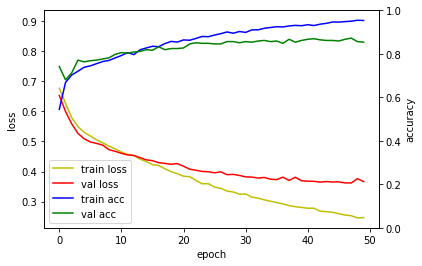

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6886 - accuracy: 0.5483 - val_loss: 0.6838 - val_accuracy: 0.5029
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6678 - accuracy: 0.6748 - val_loss: 0.6514 - val_accuracy: 0.7033
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6276 - accuracy: 0.7172 - val_loss: 0.6031 - val_accuracy: 0.7264
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5822 - accuracy: 0.7234 - val_loss: 0.5631 - val_accuracy: 0.7283
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5454 - accuracy: 0.7425 - val_loss: 0.5331 - val_accuracy: 0.7534
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5267 - accuracy: 0.7482 - val_loss: 0.5163 - val_accuracy: 0.7592
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5070 - accuracy: 0.7630 - val_loss: 0.5046 - val_accuracy: 0

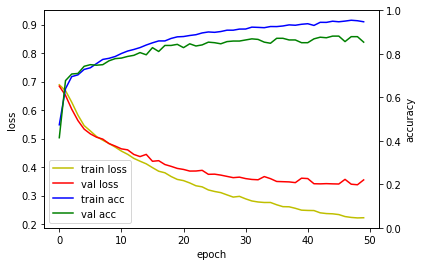

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6872 - accuracy: 0.5609 - val_loss: 0.6772 - val_accuracy: 0.5934
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6581 - accuracy: 0.6876 - val_loss: 0.6327 - val_accuracy: 0.7341
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6108 - accuracy: 0.7159 - val_loss: 0.5768 - val_accuracy: 0.7707
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5645 - accuracy: 0.7382 - val_loss: 0.5341 - val_accuracy: 0.7746
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5322 - accuracy: 0.7497 - val_loss: 0.5053 - val_accuracy: 0.7688
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5149 - accuracy: 0.7534 - val_loss: 0.4935 - val_accuracy: 0.7746
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5010 - accuracy: 0.7643 - val_loss: 0.4761 - val_accuracy: 0

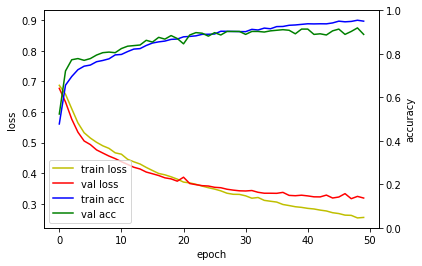

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6870 - accuracy: 0.5885 - val_loss: 0.6732 - val_accuracy: 0.7245
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6509 - accuracy: 0.6964 - val_loss: 0.6189 - val_accuracy: 0.7457
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5888 - accuracy: 0.7450 - val_loss: 0.5605 - val_accuracy: 0.7457
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5439 - accuracy: 0.7429 - val_loss: 0.5325 - val_accuracy: 0.7399
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5177 - accuracy: 0.7547 - val_loss: 0.5193 - val_accuracy: 0.7418
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5033 - accuracy: 0.7649 - val_loss: 0.5134 - val_accuracy: 0.7514
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.4910 - accuracy: 0.7634 - val_loss: 0.5091 - val_accuracy: 0

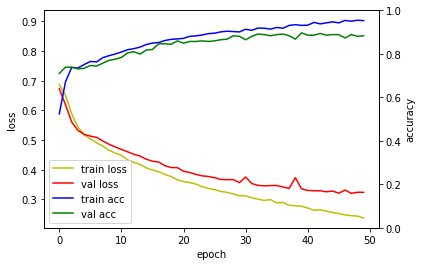

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6911 - accuracy: 0.5294 - val_loss: 0.6848 - val_accuracy: 0.6204
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6765 - accuracy: 0.6238 - val_loss: 0.6594 - val_accuracy: 0.7129
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6460 - accuracy: 0.6799 - val_loss: 0.6137 - val_accuracy: 0.7322
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5986 - accuracy: 0.7204 - val_loss: 0.5660 - val_accuracy: 0.7341
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5634 - accuracy: 0.7307 - val_loss: 0.5340 - val_accuracy: 0.7457
Epoch 6/50
146/146 [==============================] - 1s 3ms/step - loss: 0.5380 - accuracy: 0.7437 - val_loss: 0.5143 - val_accuracy: 0.7572
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5207 - accuracy: 0.7523 - val_loss: 0.4964 - val_accuracy: 0

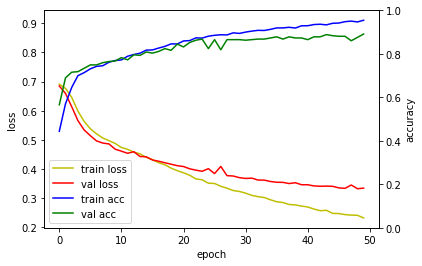

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6859 - accuracy: 0.5654 - val_loss: 0.6715 - val_accuracy: 0.6185
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6517 - accuracy: 0.6750 - val_loss: 0.6231 - val_accuracy: 0.7264
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6036 - accuracy: 0.7118 - val_loss: 0.5711 - val_accuracy: 0.7283
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5684 - accuracy: 0.7217 - val_loss: 0.5338 - val_accuracy: 0.7495
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5433 - accuracy: 0.7347 - val_loss: 0.5056 - val_accuracy: 0.7572
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5187 - accuracy: 0.7527 - val_loss: 0.4878 - val_accuracy: 0.7611
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5013 - accuracy: 0.7639 - val_loss: 0.4693 - val_accuracy: 0

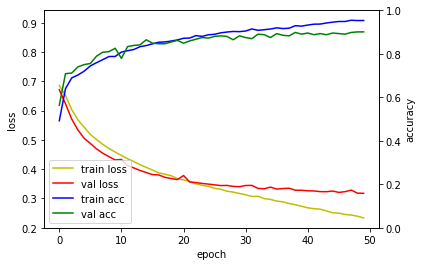

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6870 - accuracy: 0.5626 - val_loss: 0.6784 - val_accuracy: 0.6821
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6570 - accuracy: 0.6934 - val_loss: 0.6371 - val_accuracy: 0.7225
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5972 - accuracy: 0.7384 - val_loss: 0.5832 - val_accuracy: 0.7225
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5497 - accuracy: 0.7455 - val_loss: 0.5478 - val_accuracy: 0.7457
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5246 - accuracy: 0.7538 - val_loss: 0.5289 - val_accuracy: 0.7399
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5067 - accuracy: 0.7568 - val_loss: 0.5166 - val_accuracy: 0.7437
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.4971 - accuracy: 0.7592 - val_loss: 0.5088 - val_accuracy: 0

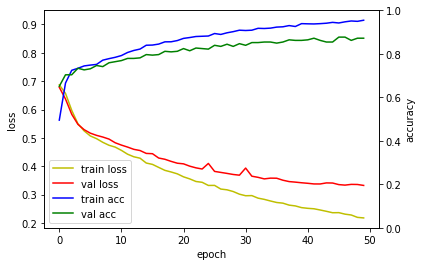

第12个：AATAAA
Epoch 1/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6907 - accuracy: 0.5322 - val_loss: 0.6857 - val_accuracy: 0.5626
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6782 - accuracy: 0.6307 - val_loss: 0.6678 - val_accuracy: 0.7495
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6493 - accuracy: 0.7118 - val_loss: 0.6330 - val_accuracy: 0.7437
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.6022 - accuracy: 0.7352 - val_loss: 0.5951 - val_accuracy: 0.7283
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5603 - accuracy: 0.7429 - val_loss: 0.5626 - val_accuracy: 0.7418
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5297 - accuracy: 0.7562 - val_loss: 0.5356 - val_accuracy: 0.7514
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.5089 - accuracy: 0.7592 - val_loss: 0.5222 - val_accuracy: 0

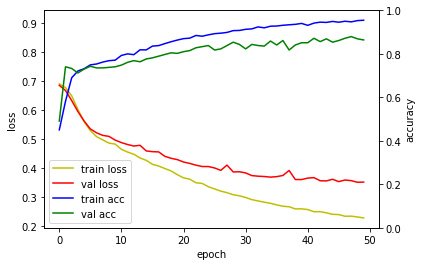

In [4]:
#每个数据单独训练预测

polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
pdata  =[name+'.txt' for name in polys]
negdata=['neg'+name  for name in pdata]

#十折交叉验证
if __name__ == "__main__":
    
    access_1=list() #12*10*5个数据
    for i in range(len(polys)):
        x1,y1=load_data(pdata[i])
        x2,y2=load_data(negdata[i])
        
        x = x1 + x2  
        x = np.asarray(x)#
        y = np.concatenate((y1,y2),axis=0) #
        
        access_2 = list()
        
        sfolder = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
        for train,test in sfolder.split(x,y):
            print("第{}个：{}".format(i+1,polys[i]))
            
            model = lenet.nerual()
            x_train,y_train = x[train],y[train]
            x_test ,y_test  = x[test],y[test]
            
            model,hist      = train_func(model,x_train,y_train,x_test,y_test)
            y_pred          = model.predict(x_test).reshape(-1)
            
            #保存训练结果
            delta           = np.array(assess_func(y_test,y_pred))
            access_2.append(delta)
            
            #查看训练过程
            %matplotlib inline
            fig,loss_ax = plt.subplots()
            acc_ax = loss_ax.twinx()
            
            loss_ax.plot(hist.history['loss'],'y',label='train loss')
            loss_ax.plot(hist.history['val_loss'],'r',label='val loss')
            loss_ax.plot(hist.history['accuracy'],'b',label='train acc')
            loss_ax.plot(hist.history['val_accuracy'],'g',label='val acc')
            
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('loss')
            acc_ax.set_ylabel('accuracy')
            
            loss_ax.legend(loc='upper left')
            loss_ax.legend(loc='lower left')
            
            plt.show()
            #if(len(access_2)==2):
            
            
        #汇总训练结果    
        access_2 = pd.DataFrame(access_2,columns=['acc','recall','pre','f1','auc'])
        access_1.append(access_2)
         
        #if(len(access_1) == 2):
        

           
        
import pickle  #保存数据
with open('access_2.dat','wb') as f:
    pickle.dump(access_1,f)


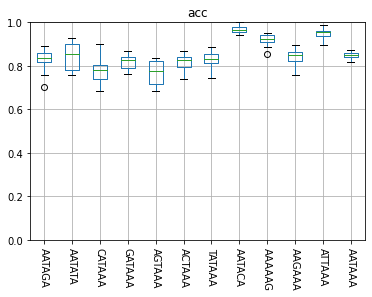

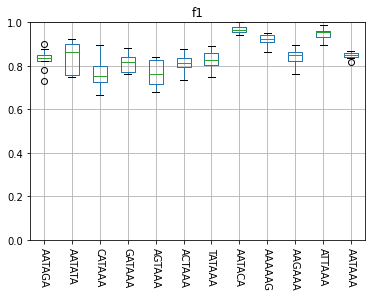

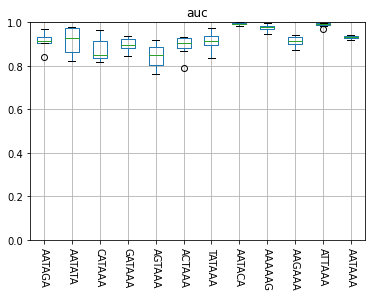

[['82.4±6', '86.4±5', '80.7±8', '83.2±5', '91.5±3'],
 ['84.6±7', '81.0±10', '87.6±7', '83.9±8', '91.4±6'],
 ['78.3±6', '71.2±9', '83.3±8', '76.5±7', '87.1±5'],
 ['81.5±4', '80.0±8', '82.9±5', '81.1±4', '89.9±3'],
 ['77.0±6', '75.8±8', '78.0±6', '76.6±6', '84.4±6'],
 ['81.7±4', '78.6±9', '84.6±7', '81.0±5', '89.5±4'],
 ['82.9±4', '81.3±7', '84.3±5', '82.6±4', '91.2±4'],
 ['96.9±2', '96.6±2', '97.3±3', '96.9±2', '99.5±0'],
 ['91.8±3', '92.2±4', '91.6±4', '91.8±3', '97.6±1'],
 ['84.0±4', '85.0±4', '83.5±5', '84.2±4', '91.3±3'],
 ['95.0±3', '95.4±3', '94.7±3', '95.0±3', '99.0±1'],
 ['84.9±2', '84.5±3', '85.3±3', '84.9±2', '93.2±1']]

In [5]:
import pickle
#加载数据
with open('access_2.dat','rb') as f:
    access_1 =  pickle.load(f)
    a = report(access_1)
a

# 2.0

In [12]:
#导入相关包
import os
os.chdir("/home/uu/proj/polyA/data/")
import numpy  as np                                    #
import pandas as pd                                    #读取数据
import keras
from keras.preprocessing.text import Tokenizer         #统计碱基频率，把碱基转化成数字
from keras.utils  import np_utils                      #将数字转化成独热码的形式
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Activation
from keras.optimizers        import Adam               #优化器
from keras.callbacks import EarlyStopping              #设置早停
from keras.callbacks import ModelCheckpoint            #
from sklearn.model_selection import StratifiedKFold    #拆分数据
from sklearn.metrics import roc_auc_score,recall_score           #引入评价指数
from sklearn.metrics import precision_score,f1_score,accuracy_score   
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt                       #绘制图形

In [13]:
delta_1=[]
delta_2=[]
#读取数据
def load_data(file=None):
    """
    输入文件名
    返回一个列表，元素为向量化后独热码后的numpy数组;
    返回numpy数组:标签
    """
    import re  #正则表达式
    df = pd.read_csv(file,header=None,names=['sequences'])
    df.loc[:,'sequences'] = df.loc[:,'sequences'].map(lambda x: list(x)) #显式索引
    
    #向量化
    vocabulary_size=10   #设定词汇量大小，因为只有4个碱基，所以设置为10
    tokenizer = Tokenizer(num_words = vocabulary_size) #初始化tokenizer函数
    tokenizer.fit_on_texts(df.loc[:,'sequences'])       #统计词汇，基于词频率
    sequences = tokenizer.texts_to_sequences(df.loc[:,'sequences']) #将atcg转化成数字1-4
    
    #删除每条序列中6个序列,然后转化为numpy数组，并设置数组元素范围为0-3,方便独热码时生成200*4的数组
    for i in range(len(sequences)):
            del sequences[i][100:106]
    sequences = np.asarray(sequences)-1
    
    #每一条序列已经是200个数字的向量
    #将200个数字(0-3)的向量转化成独热码，即200*4的矩阵,#然后重复2遍
    data = [np_utils.to_categorical(x) for x in sequences]
    data = [n.reshape((1,200,4)) for n in data]
    #data=[np.concatenate((i,i),axis=0) for i in data]
    
    #增加标签数据        
    if re.findall("neg",file):
        label = np.zeros(len(data))
    else:
        label = np.ones(len(data))
    
    return data,label

class lenet:#经典网络
    """ 网络参数"""
    def nerual():
        input_shape=(1,200,4)
        model = Sequential()
        model.add(Conv2D(filters=16,kernel_size=(3,4),padding='same',activation='relu',
                  input_shape=input_shape))
        model.add(Conv2D(filters=64,kernel_size=(6,4),padding='same',activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2),padding='same'))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        return model
        
def train_func(model,x_train=None,y_train=None):
    """编译与训练模型"""
    adam=Adam(lr=0.5*1e-4)
    model.compile(loss='binary_crossentropy',optimizer=adam,
                  metrics=['accuracy'])
    
    early_stopping=EarlyStopping(monitor='val_accuracy',patience=70,min_delta=0,verbose=0,mode='auto')
    
    filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    filepath="weights-best.hdf5"
    if os.path.exists(filepath):  # 如果文件存在
        os.remove(filepath)
    if not os.path.exists(filepath):
        os.mknod(filepath)
    callbacks_list = [early_stopping]
    checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',save_weights_only=True,
                                 verbose=1,save_best_only=True, period=1,mode='max')
    hist = model.fit(x=x_train,y=y_train,batch_size=64,validation_split=0.2,
                         epochs=250,verbose=0,shuffle=True,callbacks = callbacks_list)
    
    #model.load_weights(filepath)
    
    return model,hist

def assess_func(y_true,y_pred):
    """
    返回TP,FP,TN,FN,
    Precision   预测为正例的样本中真正正例的比例,敏感性
    recall      真正为正例的样本有多少被预测出来，
    ROC曲线      ROC是一个用于度量分类中的非均衡性的工具，ROC曲线及AUC常被用来评价一个二值分类器的优劣  
    FPR         所有的负样本中有多少被预测为正例
    TPR         等同于recall
    F-measure   precison和recall的调和平均值。没有一个单个的度量可以告诉所有的信息，所以建议使用多个度量
    """
    
    acc       = accuracy_score( y_true,np.array(y_pred>0.5,dtype=int))
    recall    = recall_score  ( y_true,np.array(y_pred>0.5,dtype=int))
    precision = precision_score(y_true,np.array(y_pred>0.5,dtype=int))
    f1        = f1_score      ( y_true,np.array(y_pred>0.5,dtype=int))
    auc       = roc_auc_score ( y_true,y_pred)  #返回的是auc
    
    
    return (acc,recall,precision,f1,auc)

def report(result_total):
    polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
    mean_std=[]
    mean_std_2=[]
    
    #数据报表，各种指标为平均值±std
    for a in [i.describe().loc['mean':'std',:] for i in result_total]:
        mean_std_2=[]
        for i in range(5):
            delta = "{:.1f}±{:.0f}".format(a.iloc[0,i]*100,a.iloc[1,i]*100)
            mean_std_2.append(delta)
        mean_std.append(mean_std_2)
        
    acc    = pd.DataFrame(np.array([i.loc[:,'acc'] for i in access_1]).T,columns=polys)
    pre    = pd.DataFrame(np.array([i.loc[:,'pre'] for i in access_1]).T,columns=polys)
    recall = pd.DataFrame(np.array([i.loc[:,'recall'] for i in access_1]).T,columns=polys)
    f1     = pd.DataFrame(np.array([i.loc[:,'f1'] for i in access_1]).T,columns=polys)
    auc    = pd.DataFrame(np.array([i.loc[:,'auc'] for i in access_1]).T,columns=polys)
    
    return(mean_std)

第1个：AATAGA
[0.75806452 0.77419355 0.75       0.76190476 0.89906348]


KeyError: 'acc'

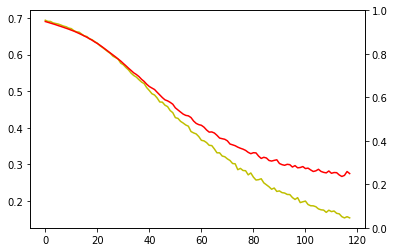

In [14]:
    
    
polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
pdata  =[name+'.txt' for name in polys]
negdata=['neg'+name  for name in pdata]

#十折交叉验证
if __name__ == "__main__":
    #初始化随机变量
    np.random.seed(3)  
    #定义变量保存训练结果
    result_total   = list()  #
    result_single  = list()  #
    result_delta   = list()  #临时变量
    
    for i in range(len(polys)):
        #读取数据,
        x1,y1=load_data(pdata[i])
        x2,y2=load_data(negdata[i])
        
        x = np.asarray(x1+x2)              #两个列表相加并转为numpy数组
        y = np.concatenate((y1,y2),axis=0) #
        
        #采用5折交叉验证，分成6个集合，其中4个为训练集，1个验证集，1个测试集
        #sfolder分成6个数据集，train集中20%用于验证，即达到4个训练集、1个验证集和1个测试集的设置
        sfolder = StratifiedKFold(n_splits=6,random_state=0,shuffle=True)
        for train,test in sfolder.split(x,y):
            #打乱训练和测试数据集
            np.random.shuffle(train)
            np.random.shuffle(test)
            
            x_train,y_train = x[train],y[train]
            x_test,y_test   = x[test],y[test]
            
            #当前训练批次
            print("第{}个：{}".format(i+1,polys[i])) 
            model = lenet.nerual()
            model,hist      = train_func(model,x_train,y_train)
            
            #用测试集评价
            y_pred          = model.predict(x_test).reshape(-1)
            result_delta    = np.array(assess_func(y_test,y_pred))
            result_single.append(result_delta)
            print(result_delta)
            
            #查看训练过程
            %matplotlib inline
            fig,loss_ax = plt.subplots()
            acc_ax = loss_ax.twinx()
            
            loss_ax.plot(hist.history['loss'],'y',label='train loss')
            loss_ax.plot(hist.history['val_loss'],'r',label='val loss')
            loss_ax.plot(hist.history['acc'],'b',label='train acc')
            loss_ax.plot(hist.history['val_acc'],'g',label='val acc')
            
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('loss')
            acc_ax.set_ylabel('accuracy')
            
            loss_ax.legend(loc='upper left')
            loss_ax.legend(loc='lower left')
            
            plt.show()
            #if(len(access_2)==2):
            
            
        #汇总训练结果
        result_total.append(pd.DataFrame(result_single,columns=['acc','recall','precision','f1','auc']))
        result_single=list()
         


if False:
    import pickle  #保存数据
    with open('result.dat','wb') as f:
        pickle.dump(result_total,f)



In [23]:
import pickle
#加载数据
with open('access_2.dat','rb') as f:
    access_1 =  pickle.load(f)
    a = report(access_1)
a

[['84.3±4', '83.9±11', '85.7±7', '84.0±5', '92.1±3'],
 ['84.9±9', '82.9±13', '86.3±8', '84.3±10', '90.4±7'],
 ['78.8±6', '76.1±9', '80.7±6', '78.1±6', '86.0±5'],
 ['80.2±8', '77.8±10', '82.0±9', '79.7±8', '88.9±8'],
 ['75.5±7', '72.8±12', '76.6±6', '74.5±9', '83.7±7'],
 ['81.9±6', '78.5±11', '84.3±6', '81.0±7', '88.4±5'],
 ['84.1±3', '83.1±3', '85.1±5', '84.0±3', '91.6±3'],
 ['97.0±2', '96.6±3', '97.5±3', '97.0±2', '99.5±0'],
 ['91.9±3', '90.6±5', '93.2±4', '91.7±3', '97.5±1'],
 ['83.7±5', '83.2±6', '84.1±5', '83.6±5', '91.5±3'],
 ['94.0±3', '92.2±4', '95.7±4', '93.8±3', '98.5±1'],
 ['85.6±1', '85.0±3', '86.2±3', '85.6±1', '93.4±1']]

# 3.0

In [6]:
delta_1=[]
delta_2=[]
#读取数据
def load_data(file=None):
    """
    输入文件名
    返回一个列表，元素为向量化后独热码后的numpy数组;
    返回numpy数组:标签
    """
    import re  #正则表达式
    df = pd.read_csv(file,header=None,names=['sequences'])
    df.loc[:,'sequences'] = df.loc[:,'sequences'].map(lambda x: list(x)) #显式索引
    
    #向量化
    vocabulary_size=10   #设定词汇量大小，因为只有4个碱基，所以设置为10
    tokenizer = Tokenizer(num_words = vocabulary_size) #初始化tokenizer函数
    tokenizer.fit_on_texts(df.loc[:,'sequences'])       #统计词汇，基于词频率
    sequences = tokenizer.texts_to_sequences(df.loc[:,'sequences']) #将atcg转化成数字1-4
    
    #删除每条序列中6个序列,然后转化为numpy数组，并设置数组元素范围为0-3,方便独热码时生成200*4的数组
    for i in range(len(sequences)):
            del sequences[i][100:106]
    sequences = np.asarray(sequences)-1
    
    #每一条序列已经是200个数字的向量
    #将200个数字(0-3)的向量转化成独热码，即200*4的矩阵,#然后重复2遍
    data = [np_utils.to_categorical(x) for x in sequences]
    data = [n.reshape((1,200,4)) for n in data]
    #data=[np.concatenate((i,i),axis=0) for i in data]
    
    #增加标签数据        
    if re.findall("neg",file):
        label = np.zeros(len(data))
    else:
        label = np.ones(len(data))
    
    return data,label

class lenet:#经典网络
    """ 网络参数"""
    def nerual():
        input_shape=(1,200,4)
        model = Sequential()
        model.add(Conv2D(filters=16,kernel_size=(3,4),padding='same',activation='relu',
                  input_shape=input_shape))
        model.add(Conv2D(filters=128,kernel_size=(6,4),padding='same',activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2),padding='same'))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        return model
        
def train_func(model,x_train=None,y_train=None):
    """编译与训练模型"""
    adam=Adam(lr=0.5*1e-4)
    model.compile(loss='binary_crossentropy',optimizer=adam,
                  metrics=['accuracy'])
    
    early_stopping_1 = EarlyStopping(monitor='val_acc',patience=70,min_delta=0,verbose=0,mode='auto')
    early_stopping_2 = EarlyStopping(monitor='val_loss',patience=50,min_delta=0,verbose=0,mode='auto')
    
    filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
    filepath="weights-best.hdf5-777777777"
    if os.path.exists(filepath):  # 如果文件存在
        os.remove(filepath)
    if not os.path.exists(filepath):
        os.mknod(filepath)
        
    callbacks_list = [early_stopping_1,early_stopping_2]
    checkpoint = ModelCheckpoint(filepath,monitor='val_acc',save_weights_only=True,
                                 verbose=1,save_best_only=True, period=1,mode='max')
    hist = model.fit(x=x_train,y=y_train,batch_size=64,validation_split=0.2,
                         epochs=250,verbose=0,shuffle=True,callbacks = callbacks_list)
    
    #model.load_weights(filepath)
    
    return model,hist

def assess_func(y_true,y_pred):
    """
    返回TP,FP,TN,FN,
    Precision   预测为正例的样本中真正正例的比例,敏感性
    recall      真正为正例的样本有多少被预测出来，
    ROC曲线      ROC是一个用于度量分类中的非均衡性的工具，ROC曲线及AUC常被用来评价一个二值分类器的优劣  
    FPR         所有的负样本中有多少被预测为正例
    TPR         等同于recall
    F-measure   precison和recall的调和平均值。没有一个单个的度量可以告诉所有的信息，所以建议使用多个度量
    """
    
    acc       = accuracy_score( y_true,np.array(y_pred>0.5,dtype=int))
    recall    = recall_score  ( y_true,np.array(y_pred>0.5,dtype=int))
    precision = precision_score(y_true,np.array(y_pred>0.5,dtype=int))
    f1        = f1_score      ( y_true,np.array(y_pred>0.5,dtype=int))
    auc       = roc_auc_score ( y_true,y_pred)  #返回的是auc
    
    
    return (acc,recall,precision,f1,auc)
 

In [7]:
    
polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
pdata  =[name+'.txt' for name in polys]
negdata=['neg'+name  for name in pdata]

#十折交叉验证
if __name__ == "__main__":
    #初始化随机变量
    np.random.seed(3)  
    #定义变量保存训练结果
    result_total   = list()  #
    result_single  = list()  #
    result_delta   = list()  #临时变量
    loop = 0;
    
    for i in range(len(polys)):
        #读取数据,
        x1,y1=load_data(pdata[i])
        x2,y2=load_data(negdata[i])
        
        x = np.asarray(x1+x2)              #两个列表相加并转为numpy数组
        y = np.concatenate((y1,y2),axis=0) #
        
        #采用5折交叉验证，分成6个集合，其中4个为训练集，1个验证集，1个测试集
        #sfolder分成6个数据集，train集中20%用于验证，即达到4个训练集、1个验证集和1个测试集的设置
        sfolder = StratifiedKFold(n_splits=6,random_state=0,shuffle=True)
        for train,test in sfolder.split(x,y):
            #打乱训练和测试数据集
            np.random.shuffle(train)
            np.random.shuffle(test)
            
            x_train,y_train = x[train],y[train]
            x_test,y_test   = x[test],y[test]
            
            #当前训练批次
            print("第{}个：{}".format(i+1,polys[i])) 
            model = lenet.nerual()
            model,hist      = train_func(model,x_train,y_train)
            
            #用测试集评价
            y_pred          = model.predict(x_test).reshape(-1)
            result_delta    = np.array(assess_func(y_test,y_pred))
            result_single.append(result_delta)
            print(result_delta)
            
            #查看训练过程
            %matplotlib inline
            fig,loss_ax = plt.subplots()
            acc_ax = loss_ax.twinx()
            
            loss_ax.plot(hist.history['loss'],'y',label='train loss')
            loss_ax.plot(hist.history['val_loss'],'r',label='val loss')
            loss_ax.plot(hist.history['acc'],'b',label='train acc')
            loss_ax.plot(hist.history['val_acc'],'g',label='val acc')
            
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('loss')
            acc_ax.set_ylabel('accuracy')
            
            loss_ax.legend(loc='upper left')
            loss_ax.legend(loc='lower left')
            
            plt.show()
            #if(len(access_2)==2):
            
            
        #汇总训练结果
        result_total.append(pd.DataFrame(result_single,columns=['acc','recall','precision','f1','auc']))
        result_single=list()
         



第1个：AATAGA


KeyboardInterrupt: 

# 4.0 交叉验证

In [44]:
#读取数据
delta_1=[]
delta_2=[]
polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
pdata  =[name+'.txt' for name in polys]
negdata=['neg'+name  for name in pdata]

def load_data(file=None):
    """
    输入文件名
    返回一个列表，元素为向量化后独热码后的numpy数组;
    返回numpy数组:标签
    """
    import re  #正则表达式
    df = pd.read_csv(file,header=None,names=['sequences'])
    df.loc[:,'sequences'] = df.loc[:,'sequences'].map(lambda x: list(x)) #显式索引
    
    #向量化
    vocabulary_size=10   #设定词汇量大小，因为只有4个碱基，所以设置为10
    tokenizer = Tokenizer(num_words = vocabulary_size) #初始化tokenizer函数
    tokenizer.fit_on_texts(df.loc[:,'sequences'])       #统计词汇，基于词频率
    sequences = tokenizer.texts_to_sequences(df.loc[:,'sequences']) #将atcg转化成数字1-4
    
    #删除每条序列中6个序列,然后转化为numpy数组，并设置数组元素范围为0-3,方便独热码时生成200*4的数组
    #for i in range(len(sequences)):
    #        del sequences[i][100:106]
    sequences = np.asarray(sequences)-1
    
    #每一条序列已经是200个数字的向量
    #将200个数字(0-3)的向量转化成独热码，即200*4的矩阵,#然后重复2遍
    data = [np_utils.to_categorical(x) for x in sequences]
    data = [n.reshape((1,206,4)) for n in data]
    #data=[np.concatenate((i,i),axis=0) for i in data]
    
    #增加标签数据        
    if re.findall("neg",file):
        label = np.zeros(len(data))
    else:
        label = np.ones(len(data))
    return data,label

class lenet:#经典网络
    """ 网络参数"""
    def nerual():
        input_shape=(1,206,4)
        model = Sequential()
        model.add(Conv2D(filters=16,kernel_size=(3,4),padding='same',activation='relu',
                  input_shape=input_shape))
        model.add(Conv2D(filters=128,kernel_size=(6,4),padding='same',activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2),padding='same'))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        return model
        
def train_func_old(model,polys,runs=1,n_splits=5):
    """编译与训练模型"""
    def train(model,x,y):
        adam = Adam(lr=5*1e-5)
        model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
        checkpoint = ModelCheckpoint(filepath,monitor='val_loss',save_weights_only=True,
                                     verbose=1,save_best_only=True, period=1,mode='max')
        early_stopping_1 = EarlyStopping(monitor='val_acc',patience=70,min_delta=0,verbose=0,mode='auto')
        early_stopping_2 = EarlyStopping(monitor='val_loss',patience=50,min_delta=0,verbose=0,mode='auto')
        callbacks_list   = [early_stopping_1,early_stopping_2]
    
        filepath="{}-{}-weights.hdf5".format(polys+1,runs)
        if os.path.exists(filepath):  # 如果文件存在
            model.load_weights()
        else:
            hist = model.fit(x=x,y=y,batch_size=64,validation_split=0.2,
                         epochs=250,verbose=1,shuffle=True,callbacks = callbacks_list)
            os.mknod(filepath)
            model.save_weights(filepath)
        return model
        
    #load_data
    x1,y1=load_data(pdata[i]  )
    x2,y2=load_data(negdata[i])
    
    x = np.asarray(x1+x2)              #两个列表相加并转为numpy数组
    y = np.concatenate((y1,y2),axis=0) #
    
    #采用五折交叉验证，从五次训练中，保留测试结果权重
    sfolder = StratifiedKFold(n_splits=n_splits,random_state=0,shuffle=True)
    for train,test in sfolder.split(x,y):
        #打乱训练和测试数据集
        np.random.shuffle(train)
        np.random.shuffle(test)

        x_train,y_train = x[train],y[train]
        x_test,y_tes   = x[test],y[test]
         
        #训练训练集
        model = train(model,x_train,y_train,)

        #用测试集评价
        y_pred          = model.predict(x_test).reshape(-1)
        result_delta    = np.array(assess_func(y_test,y_pred))
        result_single.append(result_delta)
    
    index = np.array(range(len(y)))
    np.random.shuffle(index)
    x=x[index]
    y=y[index]
    
def train_func(model,polys,runs=1,n_splits=5):
    """编译与训练模型"""

    adam = Adam(lr=5*1e-5)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    #checkpoint = ModelCheckpoint(filepath,monitor='val_loss',save_weights_only=True,
    #                             verbose=1,save_best_only=True, period=1,mode='max')
    early_stopping_1 = EarlyStopping(monitor='val_acc',patience=70,min_delta=0,verbose=0,mode='auto')
    early_stopping_2 = EarlyStopping(monitor='val_loss',patience=50,min_delta=0,verbose=0,mode='auto')
    callbacks_list   = [early_stopping_1,early_stopping_2]

    filepath="{}-weights.hdf5".format(polys+1)
    if os.path.exists(filepath):  # 如果文件存在
        model.load_weights(filepath)
    else:
        hist = model.fit(x=x,y=y,batch_size=64,validation_split=0.2,
                     epochs=250,verbose=1,shuffle=True,callbacks = callbacks_list)
        os.mknod(filepath)
        model.save_weights(filepath)
    return model

def assess_func(y_true,y_pred):
    """
    返回TP,FP,TN,FN,
    Precision   预测为正例的样本中真正正例的比例,敏感性
    recall      真正为正例的样本有多少被预测出来，
    ROC曲线      ROC是一个用于度量分类中的非均衡性的工具，ROC曲线及AUC常被用来评价一个二值分类器的优劣  
    FPR         所有的负样本中有多少被预测为正例
    TPR         等同于recall
    F-measure   precison和recall的调和平均值。没有一个单个的度量可以告诉所有的信息，所以建议使用多个度量
    """
    
    acc       = accuracy_score( y_true,np.array(y_pred>0.5,dtype=int))
    recall    = recall_score  ( y_true,np.array(y_pred>0.5,dtype=int))
    precision = precision_score(y_true,np.array(y_pred>0.5,dtype=int))
    f1        = f1_score      ( y_true,np.array(y_pred>0.5,dtype=int))
    auc       = roc_auc_score ( y_true,y_pred)  #返回的是auc
    
    
    return (acc,recall,precision,f1,auc)

def report(result_total):
    polys="AATAGA AATATA CATAAA GATAAA AGTAAA ACTAAA TATAAA AATACA AAAAAG AAGAAA ATTAAA AATAAA".split(" ")
    mean_std=[]
    mean_std_2=[]
    
    #数据报表，各种指标为平均值±std
    for a in [i.describe().loc['mean':'std',:] for i in result_total]:
        mean_std_2=[]
        for i in range(5):
            delta = "{:.1f}±{:.0f}".format(a.iloc[0,i]*100,a.iloc[1,i]*100)
            mean_std_2.append(delta)
        mean_std.append(mean_std_2)
        
    acc    = pd.DataFrame(np.array([i.loc[:,'acc'] for i in access_1]).T,columns=polys)
    pre    = pd.DataFrame(np.array([i.loc[:,'pre'] for i in access_1]).T,columns=polys)
    recall = pd.DataFrame(np.array([i.loc[:,'recall'] for i in access_1]).T,columns=polys)
    f1     = pd.DataFrame(np.array([i.loc[:,'f1'] for i in access_1]).T,columns=polys)
    auc    = pd.DataFrame(np.array([i.loc[:,'auc'] for i in access_1]).T,columns=polys)
    
    return(mean_std)    
    

def model_access(i,n_splits=5):
    #load data
    x1,y1=load_data(pdata[i]  )
    x2,y2=load_data(negdata[i])

    x = np.asarray(x1+x2)              #两个列表相加并转为numpy数组
    y = np.concatenate((y1,y2),axis=0) #   

    #分成5个集合，预测结果取平均值
    
    sfolder = StratifiedKFold(n_splits=n_splits,random_state=0,shuffle=True)
    for train,test in sfolder.split(x,y):
        #打乱训练和测试数据集
        np.random.shuffle(train)
        np.random.shuffle(test)

        x_train,y_train = x[train],y[train]
        x_test,y_test   = x[test],y[test]

        #当前批次
        print("第{}个：{}".format(i+1,polys[i])) 

        #用测试集评价
        y_pred          = model.predict(x_test).reshape(-1)
        result_delta    = np.array(assess_func(y_test,y_pred))
        result_single.append(result_delta)

    #汇总训练结果
    result_total.append(pd.DataFrame(result_single,columns=['acc','recall','precision','f1','auc']))
    result_single=list()  

In [51]:

def run(poly_1,poly_2):
    #初始化随机变量
    np.random.seed(3)  
    #定义变量保存训练结果
    result_total   = list()  #
    result_single  = list()  #
    result_delta   = list()  #临时变量
    loop = 0;
    
    #训练模型
    model = lenet.nerual()
    model = train_func(model,polys=poly_1)
    
    #模型评价
    for i in (poly_2,):
        #读取数据,
        x1,y1=load_data(pdata[i]  )
        x2,y2=load_data(negdata[i])
        
        x = np.asarray(x1+x2)              #两个列表相加并转为numpy数组
        y = np.concatenate((y1,y2),axis=0) #
        
        #分成5个集合，预测结果取平均值
        #sfolder分成6个数据集，train集中20%用于验证，即达到4个训练集、1个验证集和1个测试集的设置
        sfolder = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
        for train,test in sfolder.split(x,y):
            
            #打乱训练和测试数据集
            np.random.shuffle(train)
            np.random.shuffle(test)
            
            x_train,y_train = x[train],y[train]
            x_test,y_test   = x[test],y[test]
            
            #当前批次
            print("第{}个：{}".format(i+1,polys[i])) 
            
            #用测试集评价
            y_pred          = model.predict(x_test).reshape(-1)
            result_delta    = np.array(assess_func(y_test,y_pred))
            result_single.append(result_delta)
            
        #汇总训练结果
        result_total.append(pd.DataFrame(result_single,columns=['acc','recall','precision','f1','auc']))
        result_single=list()
    return result_total    
    



In [73]:

d = run(10,6)[0]
a=[]
# "{:.1f}±{:.0f}".format(d.descibe() ,d.std()[0]*100  )
for  i in range(5):
    delta = "{:.1f}±{:.0f}".format(d.describe().loc['mean',:][i]*100,d.describe().loc['std',:][i]*100)
    a.append(delta)
a

第7个：TATAAA
第7个：TATAAA
第7个：TATAAA
第7个：TATAAA
第7个：TATAAA


['95.9±1', '93.6±4', '98.2±2', '95.8±1', '99.1±0']

In [38]:
c=[]
for a,b in sfolder.split(np.zeros((12,)),np.ones((12,))):
    c.append(b)
print(c)

[array([ 6, 11]), array([ 4, 10]), array([2, 8]), array([1, 7]), array([3, 9]), array([0, 5])]
